In [3]:
import sys; sys.path.append('/home/clair/wwa'); from wwa import *
from matplotlib import gridspec
import warnings
warnings.filterwarnings("ignore")    # because pcolormesh doesn't like being given cell centres instead of vertices

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# Define projection to be used for all maps
cproj = cartopy.crs.epsg(3347)  # native EPSG of homogenous fire regions
cproj.bounds = (3393069.0021458385, 9436930.849558635, 750000, 4340847.387925235)      # modify bounds to focus on region of interest

hfrz = gpd.read_file("sf_hfrz")
hfrz_px = {'ES':  (7400000, 2350000),
           'GSL': (4880000, 2990000),
           'SC': (4100000, 2100000),
           'LW': (5800000, 1990000),
           'ET': (7000000, 1250000),
           'LA':  (5300000, 2500000),
           'EJB':  (7350000, 1650000),
           'IC':  (4280000, 2900000),
           'WO':  (6200000, 1670000),
           'WS':  (5700000, 2780000),
           'GBL':  (4650000, 3450000),
           'WJB':  (6600000, 1700000),
           'SY':  (4000000, 3600000),
           'NAT':  (7900000, 2180000),
           'SP':  (4820000, 2390000),
           'P':  (4100000, 3200000)}

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# Method to reproject lat/lon onto Lambert coordinates
def latlon_to_lambert(da):
    
    # convert dataArray to dataframe
    df = da.to_dataframe().reset_index()
    
    # convert to geoDataFrame, reproject points to Statistics Canada Lambert 
    gdf = gpd.GeoDataFrame(df[df.columns[-1]], geometry = gpd.points_from_xy(df.longitude, df.latitude))
    gdf = gdf.set_crs(epsg = 4326).to_crs(epsg = 3347)
    
    x = np.reshape(np.array(gdf.geometry.x), da.shape)
    y = np.reshape(np.array(gdf.geometry.y), da.shape)
    
    return x,y

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# additional methods used to check distributional assumptions
from scipy.stats import kurtosis, skew, kstest, spearmanr

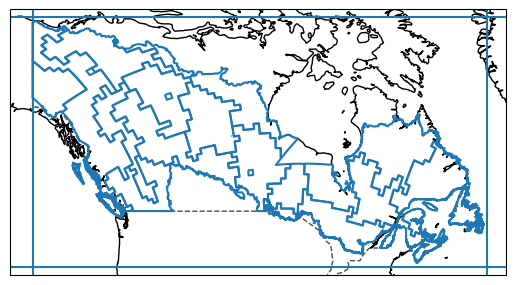

In [238]:
fig, ax = plt.subplots(subplot_kw = {"projection" : cartopy.crs.PlateCarree()})
ax.coastlines()
hfrz.to_crs(epsg = 4326).boundary.plot(ax = ax)
ax.add_feature(cartopy.feature.BORDERS, color = "k", alpha = 0.7, ls = "--")

ax.axhline(43)
ax.axhline(70)
ax.axvline(-141)
ax.axvline(-52)


In [ ]:
dsr.longitude#

<xarray.DataArray 'longitude' (longitude: 353)>
array([-140.75, -140.5 , -140.25, ...,  -53.25,  -53.  ,  -52.75])
Coordinates:
  * longitude  (longitude) float64 -140.8 -140.5 -140.2 ... -53.25 -53.0 -52.75
Attributes:
    units:          degrees_east
    standard_name:  longitude
    long_name:      longitude

---
# **Exploratory**

- make a map of danger thresholds per province & look at ndays exceeding each level
- MODIS/VIIRS active fires

## **Elevation**

In [54]:
elev = wrap_lon(xr.open_dataset("~/Data/elev.0.25-deg.nc").squeeze(drop = True).data).sel(lon = slice(-140.75, -52.75), lat = slice(43.5, 69.5))
elev = elev.assign_coords({k : (["lat", "lon"], v) for k,v in zip(["x","y"], latlon_to_lambert(elev.rename(lon = "longitude", lat = "latitude")))})

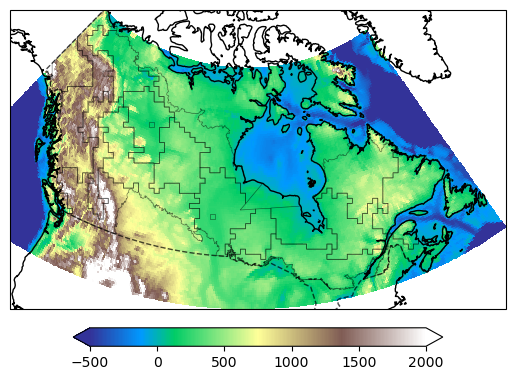

In [68]:
fig, ax = plt.subplots(subplot_kw = {"projection" : cproj})
cbar = ax.pcolormesh(elev.x, elev.y, elev, cmap = "terrain", vmin = -500, vmax = 2000)

ax.coastlines()
hfrz.boundary.plot(ax = ax, color = "k", lw = 0.5, alpha = 0.5)
ax.add_feature(cartopy.feature.BORDERS, color = "k", alpha = 0.7, ls = "--")

plt.colorbar(cbar, ax = ax, location = "bottom", fraction = 0.05, pad = 0.05, extend = "both")

## **HFRZs & provinces**

### **Map of HFRZs**

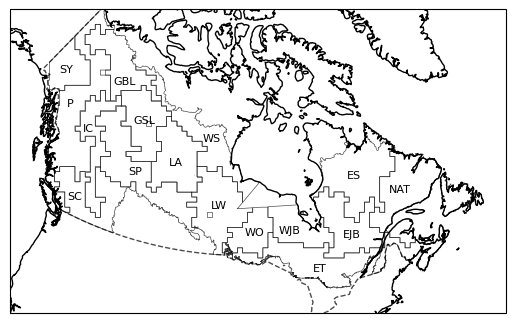

In [570]:
fig, ax = plt.subplots(subplot_kw = {"projection" : cproj}, dpi = 100)

provinces.boundary.plot(ax = ax, color = "w", alpha = 0.5, lw = 0.5, zorder = -999) # force map to same size

ax.coastlines()
hfrz.boundary.plot(ax = ax, color = "k", lw = 0.5, alpha = 0.7)
ax.add_feature(cartopy.feature.BORDERS, color = "k", alpha = 0.7, ls = "--")

[ax.annotate(k, xy = v, fontsize = 8) for k, v in hfrz_px.items()]
plt.savefig("fig/maps_hfrz.png")

### **Map of provinces**

In [87]:
provinces = gpd.read_file("sf_provinces").to_crs(cproj).set_index("PRENAME")

In [11]:
# province_px = {r[1].PREABBR : [r[1].geometry.representative_point().x, r[1].geometry.representative_point().y] for r in provinces.iterrows()}
province_px = {'N & L': [8500000, 2550000],
               'PEI.': [8200000, 1700000],
               'NS': [8500000, 1400000],
               'NB': [8030000, 1500000],
               'Quebec': [7200000, 2100000],
               'Ontario': [6200000, 1650000],
               'Man.': [5700000, 2000000],
               'Sask.': [5100000, 2100000],
               'Albta': [4600000, 2300000],
               'BC': [4100000, 2600000],
               'Yukon': [4000000, 3600000],
               'NW T': [4650000, 3400000],
               'Nvt.': [5750000, 3200000]}

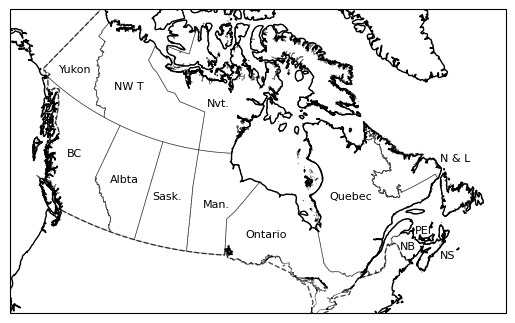

In [566]:
fig, ax = plt.subplots(subplot_kw = {"projection" : cproj}, dpi = 100)

provinces.boundary.plot(ax = ax, color = "k", alpha = 0.5, lw = 0.5)
ax.add_feature(cartopy.feature.BORDERS, color = "k", alpha = 0.7, ls = "--")

[ax.annotate(k, xy = v, fontsize = 8) for k, v in province_px.items()]
ax.coastlines()

plt.savefig("fig/maps_provinces.png")

### **Provinces with fire danger thresholds & HFRZ boundaries**

In [567]:
provinces = gpd.read_file("sf_provinces").to_crs(cproj).set_index("PRENAME")
fwi_extreme = {"fwi_extreme" : {'Newfoundland and Labrador' : 20,
               'Prince Edward Island' : 21,
               'Nova Scotia' : 23,
               'New Brunswick' : 23, 
               'Quebec' : 20,
               'Ontario' : 22,
               'Manitoba' : 33, 
               'Saskatchewan' : 30,
               'Alberta' : 29, 
               'British Columbia' : 35, # temporary value until I can get a shapefile for the smaller regions
               'Yukon' : 28, 
               'Northwest Territories' : 23,
               'Nunavut' : 23}}
provinces = pd.merge(provinces, pd.DataFrame.from_dict(fwi_extreme), left_index = True, right_index = True)

provinces[["geometry", "fwi_extreme"]].to_file("sf_firerisk")

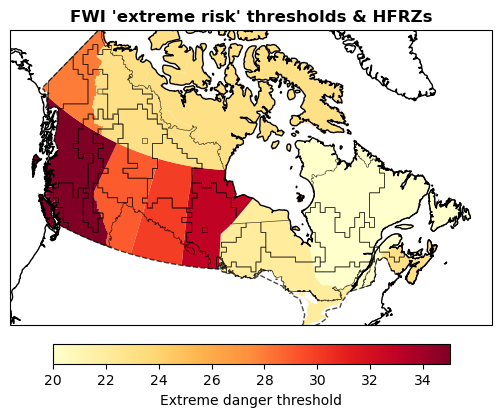

In [582]:
fig, ax = plt.subplots(subplot_kw = {"projection" : cproj})

ax.coastlines()
hfrz.boundary.plot(ax = ax, color = "k", lw = 0.5, alpha = 0.7)
ax.add_feature(cartopy.feature.BORDERS, color = "k", alpha = 0.7, ls = "--")

provinces.plot(ax = ax, column = "fwi_extreme", cmap = "YlOrRd", legend = True,
               legend_kwds={"label": "Extreme danger threshold", "orientation": "horizontal", "pad" : 0.05, "shrink" : 0.8})
plt.title("FWI 'extreme risk' thresholds & HFRZs", fontweight = "bold")

plt.savefig("fig/maps_fwi-risk-thresholds.png")

---
---
# **FWI exploratory (ERA5)**

## **Map of cumulative DSR**

In [469]:
fwi = xr.concat([xr.open_dataset(fnm).sel(time = "2023") for fnm in glob.glob("data/era5_fwi_hfrz-*.nc")], "region").fwinx
fwi = fwi.assign_coords({k : (["latitude", "longitude"], v)  for k,v in zip(["x","y"], latlon_to_lambert(fwi.isel(time = 0, region = 0)))})

dsr = (fwi ** 1.77) * 0.0272
cumdsr = dsr.sum(["region", "time"]).where(dsr.sum(["region", "time"]) > 0)

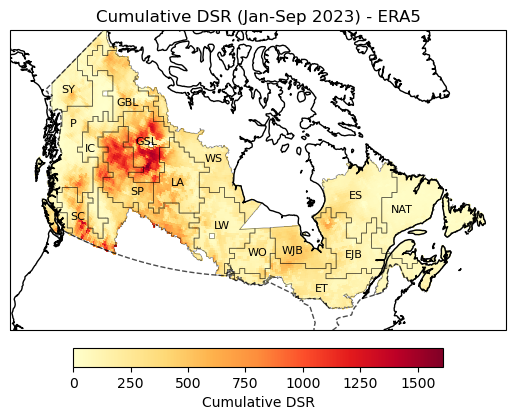

In [470]:
fig, ax = plt.subplots(subplot_kw = {"projection" : cproj})
cbar = ax.pcolormesh(cumdsr.x, cumdsr.y, cumdsr, cmap = "YlOrRd", vmin = 0)
ax.coastlines()
hfrz.boundary.plot(ax = ax, color = "k", lw = 0.5, alpha = 0.5)
ax.add_feature(cartopy.feature.BORDERS, color = "k", alpha = 0.7, ls = "--")

plt.colorbar(cbar, ax = ax, location = "bottom", fraction = 0.05, pad = 0.05, label = "Cumulative DSR")
plt.title("Cumulative DSR (Jan-Sep 2023) - ERA5")

[ax.annotate(k, xy = v, fontsize = 8) for k, v in hfrz_px.items()]

plt.savefig("fig/expl_era5_cumDSR-2023.png")

### **Number of fire danger days**

In [17]:
sf_fr = gpd.read_file("sf_firerisk").dissolve(by = "fwi_extrem").to_crs("epsg:4326")
fwi = xr.concat([xr.open_dataset(fnm).sel(time = "2023") for fnm in glob.glob("data/era5_fwi_hfrz-*.nc")], "region").fwinx

# create a regionmask of the FWI threshold for extreme fire risk
rm_fr = regionmask.mask_geopandas(sf_fr, fwi.longitude, fwi.latitude)
rm_fr = rm_fr.assign_coords({k : (["latitude", "longitude"], v)  for k,v in zip(["x","y"], latlon_to_lambert(rm_fr))})

# identify days of extreme fire risk (& mask out regions without fwi data)
fr = xr.ones_like(fwi).where(fwi >= rm_fr, 0).sum(["time", "region"])
fr = fr.where(fwi.sum(["time", "region"]) > 0)

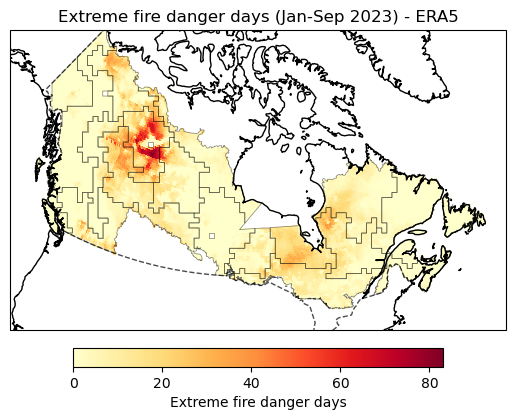

In [36]:
# number of days of extreme fire risk
fig, ax = plt.subplots(subplot_kw = {"projection" : cproj}, dpi = 100)

cbar = ax.pcolormesh(fr.x, fr.y, fr, cmap = "YlOrRd", vmin = 0)
ax.coastlines()
hfrz.boundary.plot(ax = ax, color = "k", lw = 0.5, alpha = 0.5)
ax.add_feature(cartopy.feature.BORDERS, color = "k", alpha = 0.7, ls = "--")

plt.colorbar(cbar, ax = ax, location = "bottom", fraction = 0.05, pad = 0.05, label = "Extreme fire danger days")

plt.title("Extreme fire danger days (Jan-Sep 2023) - ERA5")

plt.savefig("fig/expl_era5_fire-danger-days-2023.png")

## **Linear trend in log10(cumDSR)**

In [2]:
# cdsr = []
# for fnm in glob.glob("data/era5_fwi_hfrz-*.nc"):
#     fwi = xr.open_dataset(fnm).fwinx
#     last_day = fwi.time.max().dt.dayofyear
    
#     dsr = (fwi ** 1.77) * 0.0272
#     dsr = dsr.sel(time = [d <= last_day for d in dsr.time.dt.dayofyear])      # currently only includes data up to the end of September
#     cdsr.append(dsr.resample(time = "AS-JAN").sum().where(dsr.sum("time") > 0).rename("cdsr"))

# cdsr = xr.concat(cdsr, "region").sortby("region")
# cdsr = cdsr.assign_coords({k : (["latitude", "longitude"], v)  for k,v in zip(["x","y"], latlon_to_lambert(cdsr.isel(time = 0, region = 0)))})
# cdsr = cdsr.assign_attrs(note2 = "DSR accumulated by day "+str(last_day)+" in each year")

# cdsr.to_netcdf("data/era5_cumdsr_gridded.nc")

### **Fitted linear model**

In [271]:
# load cumDSR data, take logs & reset missing areas to NaN
log10_cdsr = np.log10(xr.open_dataset("data/era5_cumdsr_gridded.nc").cdsr.sum("region"))
log10_cdsr = log10_cdsr.where(log10_cdsr.sum("time") != 0)

# replace time with GMST for linear fitting
gmst = pd.read_csv("/home/clair/Data/gmst.dat", comment = "#", sep = " +", header = None, names = ["year", "gmst"], index_col = 0).to_xarray().sel(year = log10_cdsr.time.dt.year).gmst
log10_cdsr = log10_cdsr.assign_coords(time = gmst).rename(time = "gmst")

# fit a linear trend & get residuals
lfit = log10_cdsr.polyfit("gmst", deg = 1).polyfit_coefficients
lfitted = xr.polyval(log10_cdsr.gmst, lfit)
lres = log10_cdsr - lfitted

# relabel main axis as time, rather than GMST
lres = lres.assign_coords(gmst = lres.year).rename(gmst = "time")
log10_cdsr = log10_cdsr.assign_coords(gmst = log10_cdsr.year).rename(gmst = "time")

# estimate return period
rp = 1/norm.sf(log10_cdsr.sel(time = 2023), loc = lfitted.isel(gmst = -1), scale = lres.std("time"))

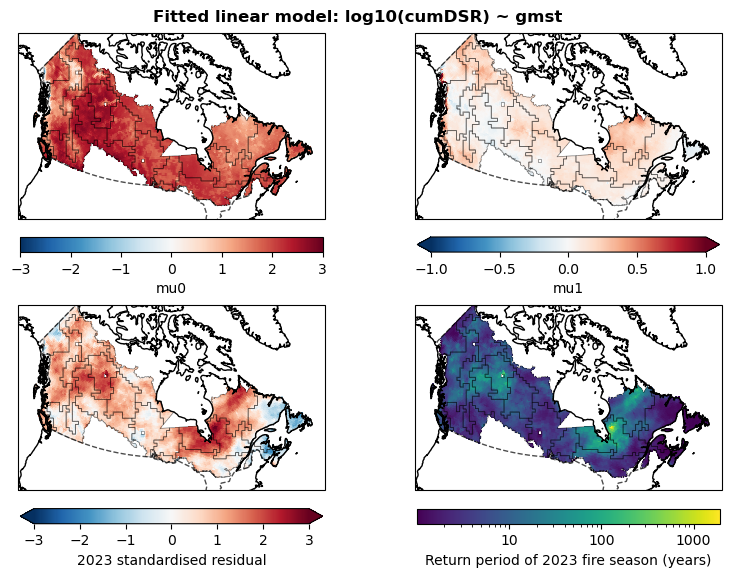

In [473]:
# fitted model at each grid cell
fig, axs = plt.subplots(ncols = 2, nrows = 2, figsize = (10, 6), dpi = 100, subplot_kw = {"projection" : cproj})
plt.subplots_adjust(wspace = 0.05, hspace = 0.2, top = 0.94)
cbar_kwargs = {"location" : "bottom", "fraction" : 0.1, "shrink" : 0.8, "pad" : 0.08}
axs = fig.axes

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
ax = axs[0]
cbar = ax.pcolormesh(lres.x, lres.y, lfit.sel(degree = 0), vmin = -3, vmax = 3, cmap = "RdBu_r")
plt.colorbar(cbar, ax = ax, **cbar_kwargs, label = "mu0")
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
ax = axs[1]
cbar = ax.pcolormesh(lres.x, lres.y, lfit.sel(degree = 1), vmin = -1, vmax = 1, cmap = "RdBu_r")
plt.colorbar(cbar, ax = ax, **cbar_kwargs, label = "mu1", extend = "both")
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
ax = axs[2]
cbar = ax.pcolormesh(lres.x, lres.y, lres.sel(time = 2023) / lres.std("time"), vmin = -3, vmax = 3, cmap = "RdBu_r")
plt.colorbar(cbar, ax = ax, **cbar_kwargs, label = "2023 standardised residual", extend = "both")
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
ax = axs[3]
cbar = plt.pcolormesh(lres.x, lres.y, rp, cmap = "viridis", norm=matplotlib.colors.LogNorm())
cbar = plt.colorbar(cbar, ax = plt.gca(), **cbar_kwargs, label = "Return period of 2023 fire season (years)")
cbar.ax.set_xticklabels([0.1,1,10,100,1000,10000,100000])

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

for ax in fig.axes[:4]:
    ax.coastlines()
    hfrz.boundary.plot(ax = ax, color = "k", lw = 0.5, alpha = 0.5)
    ax.add_feature(cartopy.feature.BORDERS, color = "k", alpha = 0.7, ls = "--")

plt.suptitle("Fitted linear model: log10(cumDSR) ~ gmst", fontweight = "bold")

plt.savefig("fig/mdl_era5_cdsr-fitted-model-gridded.jpg")

### **Check normality of log10(cumDSR)**

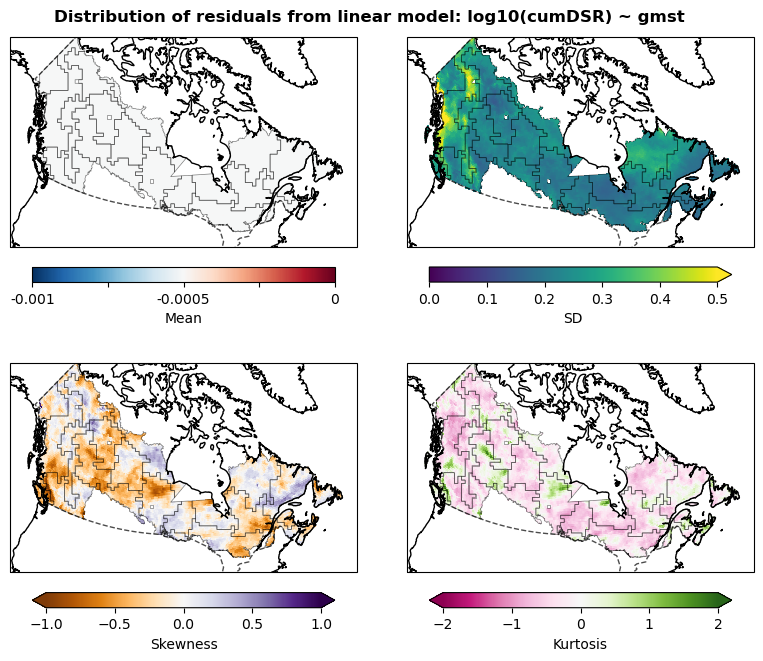

In [298]:
# check distribution of residuals
fig, axs = plt.subplots(ncols = 2, nrows = 2, figsize = (10, 7), dpi = 100, subplot_kw = {"projection" : cproj})
plt.subplots_adjust(wspace = 0.05, hspace = 0.275, top = 0.94)
cbar_kwargs = {"location" : "bottom", "fraction" : 0.1, "shrink" : 0.8, "pad" : 0.08}
axs = fig.axes

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
ax = axs[0]
cbar = ax.pcolormesh(lres.x, lres.y, lres.mean("time"), cmap = "RdBu_r", vmin = -0.001, vmax = 0.001)
cbar = plt.colorbar(cbar, ax = ax, **cbar_kwargs, label = "Mean")
cbar.ax.set_xticklabels([-.001,"",-0.0005,"",0,"",0.0005,"",0.001])

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
ax = axs[1]
cbar = ax.pcolormesh(lres.x, lres.y, lres.std("time"), vmin = 0, vmax = 0.5)
plt.colorbar(cbar, ax = ax, **cbar_kwargs, label = "SD", extend = "max")
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
ax = axs[2]
cbar = ax.pcolormesh(lres.x, lres.y, skew(lres, axis = 0), vmin = -1, vmax = 1, cmap = "PuOr")
plt.colorbar(cbar, ax = ax, **cbar_kwargs, label = "Skewness", extend = "both")
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
ax = axs[3]
cbar = ax.pcolormesh(lres.x, lres.y, kurtosis(lres, axis = 0), vmin = -2, vmax = 2, cmap = "PiYG")
plt.colorbar(cbar, ax = ax, **cbar_kwargs, label = "Kurtosis", extend = "both")
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

for ax in axs:
    ax.coastlines()
    hfrz.boundary.plot(ax = ax, color = "k", lw = 0.5, alpha = 0.5)
    ax.add_feature(cartopy.feature.BORDERS, color = "k", alpha = 0.7, ls = "--")

plt.suptitle("Distribution of residuals from linear model: log10(cumDSR) ~ gmst", fontweight = "bold")
plt.savefig("fig/mdl_era5_cdsr-linear-res-gridded.jpg")

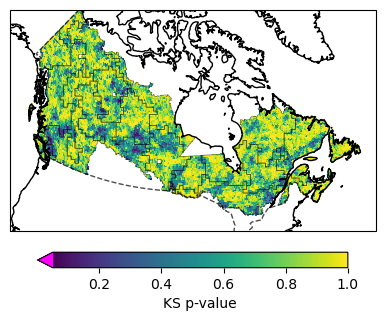

In [472]:
# see if standardised residuals could plausibly be from a standard normal distribution
ks_res = xr.apply_ufunc(lambda x : list(kstest(x, cdf = norm.cdf))[1], lres / lres.std("time"), vectorize = True, input_core_dims = [["time"]])

fig, axs = plt.subplots(ncols = 1, nrows = 1, figsize = (5, 3.5), dpi = 100, subplot_kw = {"projection" : cproj})
ks_cmap = matplotlib.cm.viridis; ks_cmap.set_under('magenta')

ax = axs
cbar = ax.pcolormesh(lres.x, lres.y, ks_res, vmin = 0.05, vmax = 1, cmap = ks_cmap)
plt.colorbar(cbar, ax = ax, **cbar_kwargs, label = "KS p-value", extend = "min")

ax.coastlines()
hfrz.boundary.plot(ax = ax, color = "k", lw = 0.5, alpha = 0.5)
ax.add_feature(cartopy.feature.BORDERS, color = "k", alpha = 0.7, ls = "--")

plt.savefig("fig/mdl_era5_cdsr-ks-test-gridded.jpg")

In [372]:
xr.ones_like(ks_res).where(ks_res <= 0.05).sum() # one single pixel where we reject the null hypothesis that the distributions are identical

## **cumDSR per HFRZ**

In [376]:
hfrz_dsr = [((xr.open_dataset(fnm).fwinx ** 1.77) * 0.0272).mean(["latitude", "longitude"]) for fnm in sorted(glob.glob("data/era5_fwi_hfrz-*.nc"))]
hfrz_dsr = xr.concat(hfrz_dsr, "region").rename("dsr")
hfrz_dsr.to_netcdf("data/era5_dsr_hfrz-ts.nc")

### **cumDSR relative to previous years**

In [37]:
hfrz_dsr = xr.open_dataset("data/era5_dsr_hfrz-ts.nc").dsr

days = pd.date_range(start = "2020-01-01", end = "2020-12-31")
labelticks = [i+1 for i in range(366) if (days[i].day) == 15]
labels = [days[i].strftime("%b")[:1] for i in range(366) if (days[i].day) == 1]

In [165]:
hfrz_cdsr = xr.concat([hfrz_dsr.sel(time = str(y)).cumsum("time") for y in range(1950,2023)], "time")

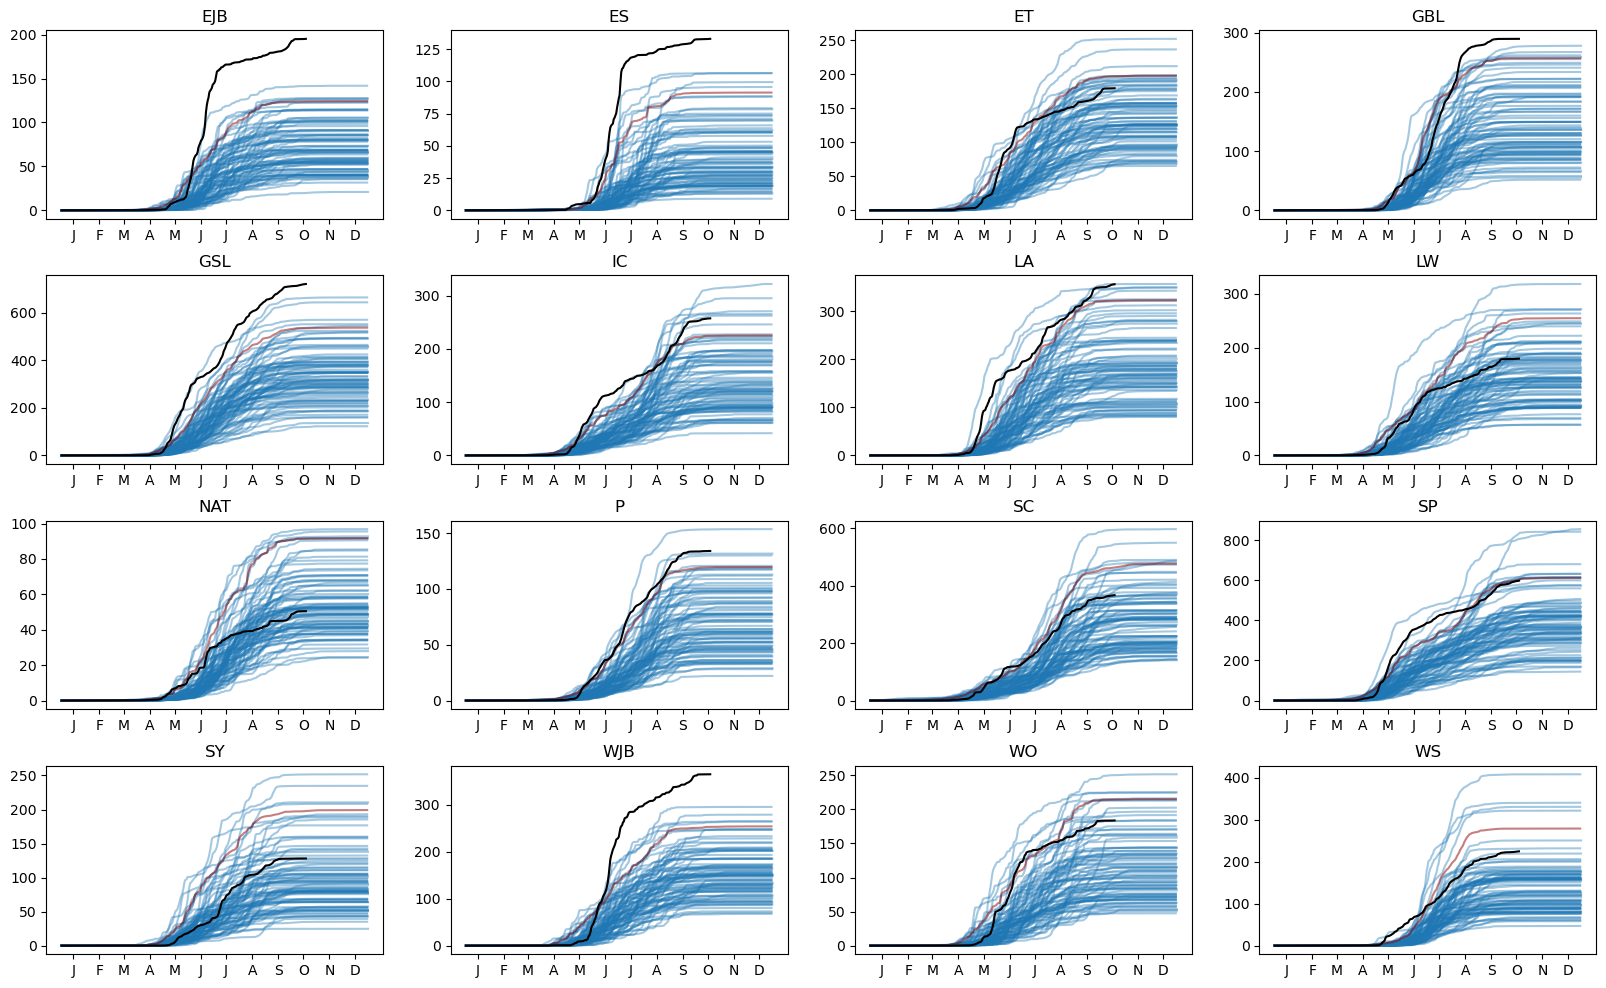

In [175]:
fig, axs = plt.subplots(ncols = 4, nrows = 4, figsize = (20,12), dpi = 100)
plt.subplots_adjust(hspace = 0.3)

for i in range(16):
    ax = fig.axes[i]
    dsr_ts = hfrz_dsr.isel(region = i)
    
    for y in range(1941,2022):
        dsr_y = dsr_ts.sel(time = str(y))
        ax.plot(dsr_y.time.dt.dayofyear, dsr_y.cumsum("time"), color = "tab:blue", alpha = 0.4)
    
    # 95th percentile of cumsum
    ax.plot(dsr_ts.sel(time = "2022").time.dt.dayofyear, hfrz_cdsr.isel(region = i).groupby("time.dayofyear").quantile(0.95)[:-1], color = "darkred", alpha = 0.5, label = "95th percentile")
    
    y = 2023
    dsr_y = dsr_ts.sel(time = str(y))
    ax.plot(dsr_y.time.dt.dayofyear, dsr_y.cumsum("time"), color = "k", alpha = 1, label = "2023")
    
    ax.set_xticks(labelticks)
    ax.set_xticklabels(labels)

    ax.set_title(dsr_ts.region_name.values)
    
plt.savefig("fig/expl_era5_cumDSR-per-hfrz.png")

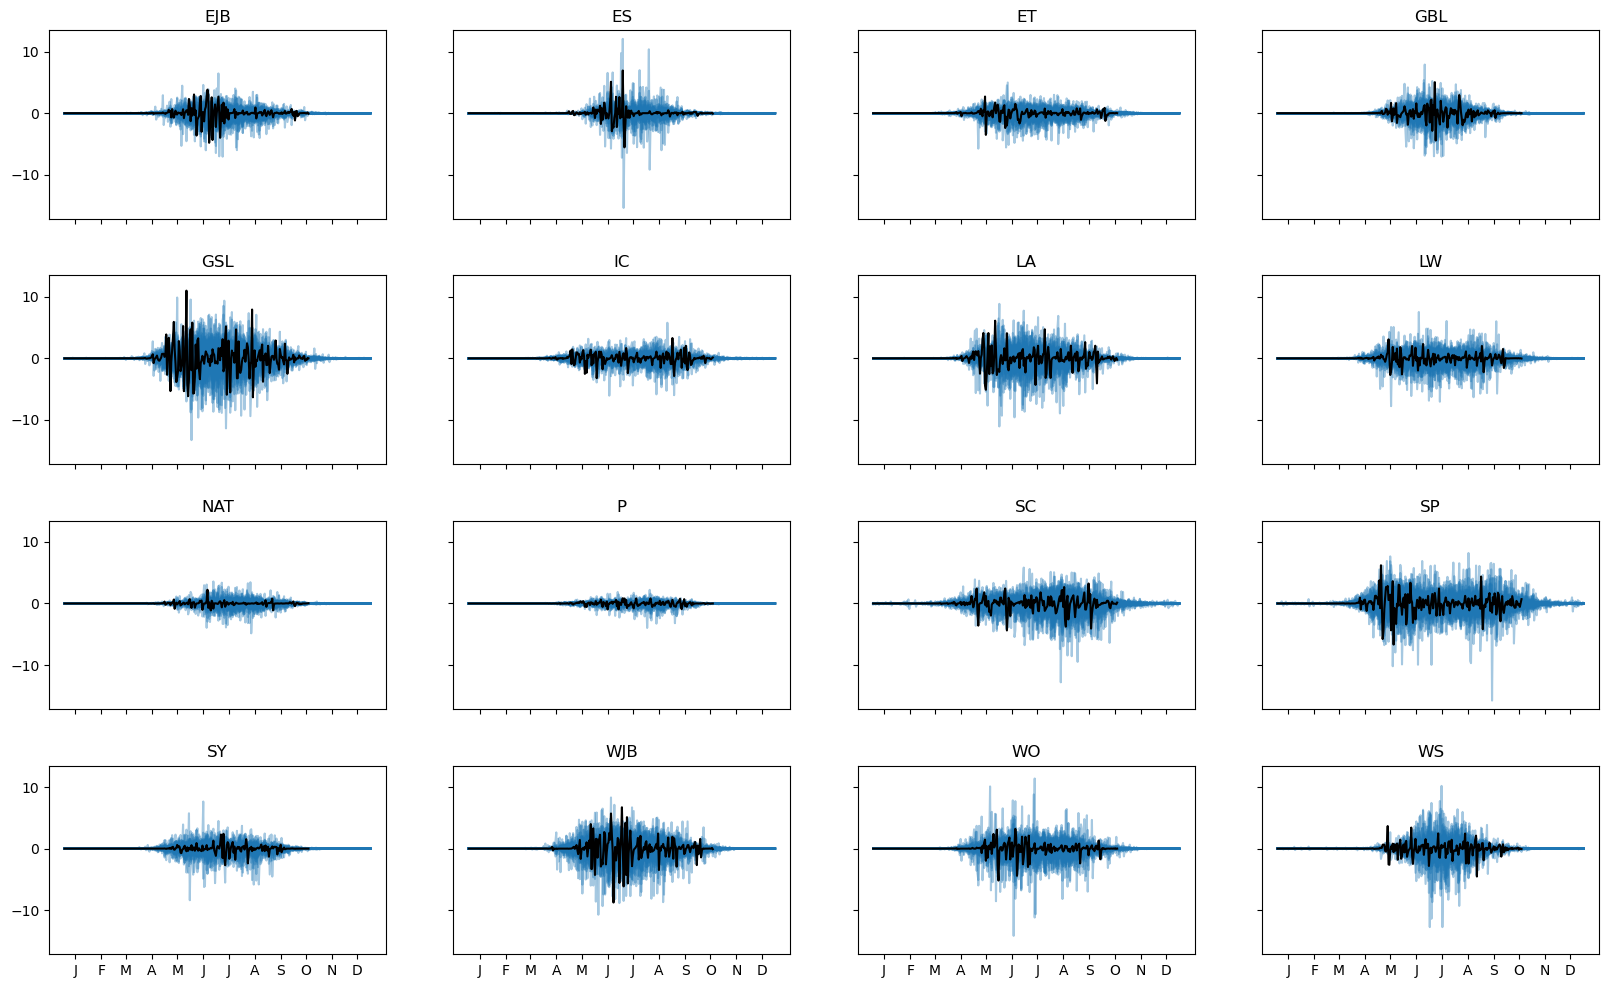

In [176]:
# when did the greatest increases occur?
fig, axs = plt.subplots(ncols = 4, nrows = 4, figsize = (20,12), dpi = 100, sharex = True, sharey = True)
plt.subplots_adjust(hspace = 0.3)

for i in range(16):
    ax = fig.axes[i]
    dsr_ts = hfrz_dsr.isel(region = i)
    
    for y in range(1941,2022):
        dsr_y = dsr_ts.sel(time = str(y))
        ax.plot(dsr_y.time.dt.dayofyear[1:], dsr_y.diff("time"), color = "tab:blue", alpha = 0.4)
        
    y = 2023
    dsr_y = dsr_ts.sel(time = str(y))
    ax.plot(dsr_y.time.dt.dayofyear[1:], dsr_y.diff("time"), color = "k", alpha = 1, label = "2023")
    
    ax.set_xticks(labelticks)
    ax.set_xticklabels(labels)

    ax.set_title(dsr_ts.region_name.values)
    
plt.savefig("fig/expl_era5_cumDSR-diff-per-hfrz.png")

### **time series of annual cumDSR (to end of September)**

In [379]:
hfrz_dsr = xr.open_dataset("data/era5_dsr_hfrz-ts.nc").dsr

# total DSR over each year (currently only up to end of September due to partial 2023 data)
cdsr = hfrz_dsr.sel(time = [m <= 9 for m in hfrz_dsr.time.dt.month]).resample(time = "AS-JAN").sum()

cdsr.assign_coords(region = cdsr.region_name, time = cdsr.time.dt.year).rename(time = "year").reset_coords(drop = True).to_pandas().transpose().to_csv("data/era5_cdsr.csv")

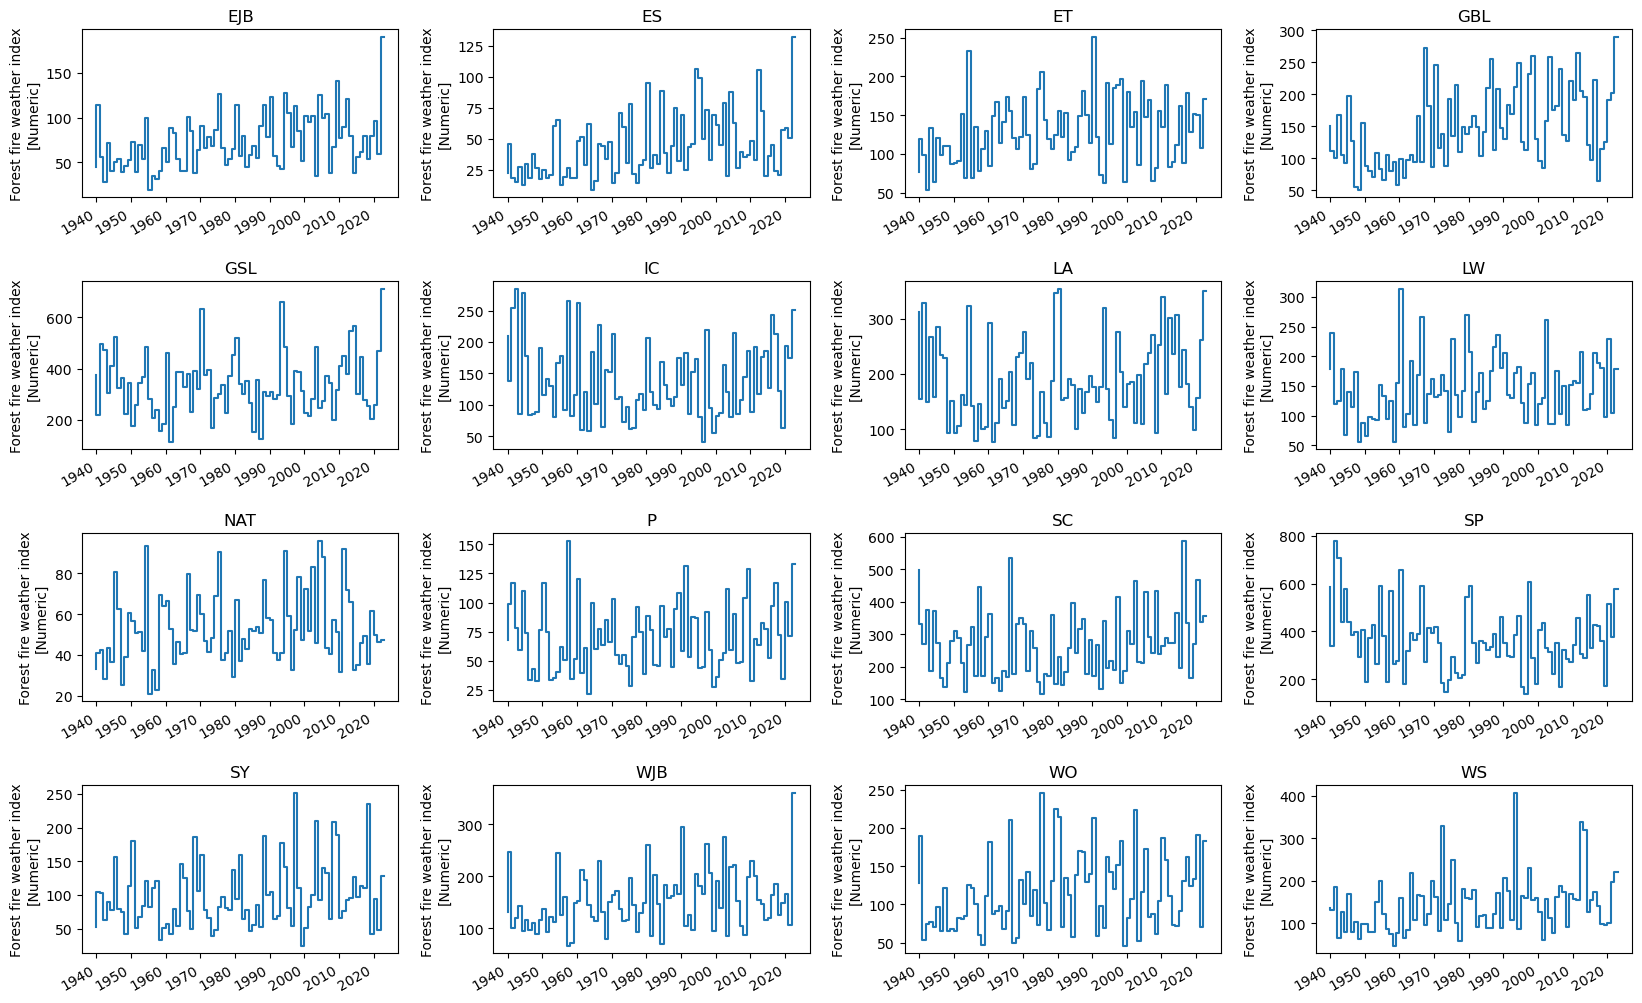

In [36]:
fig, axs = plt.subplots(ncols = 4, nrows = 4, figsize = (20,12), dpi = 100)
plt.subplots_adjust(hspace = 0.5, wspace = 0.3)

for i in range(16):
    ax = fig.axes[i]
    cdsr_ts = cdsr.isel(region = i)
    cdsr_ts.plot(ax = ax, drawstyle = "steps")

    ax.set_title(cdsr_ts.region_name.values)
    ax.set_xlabel("")

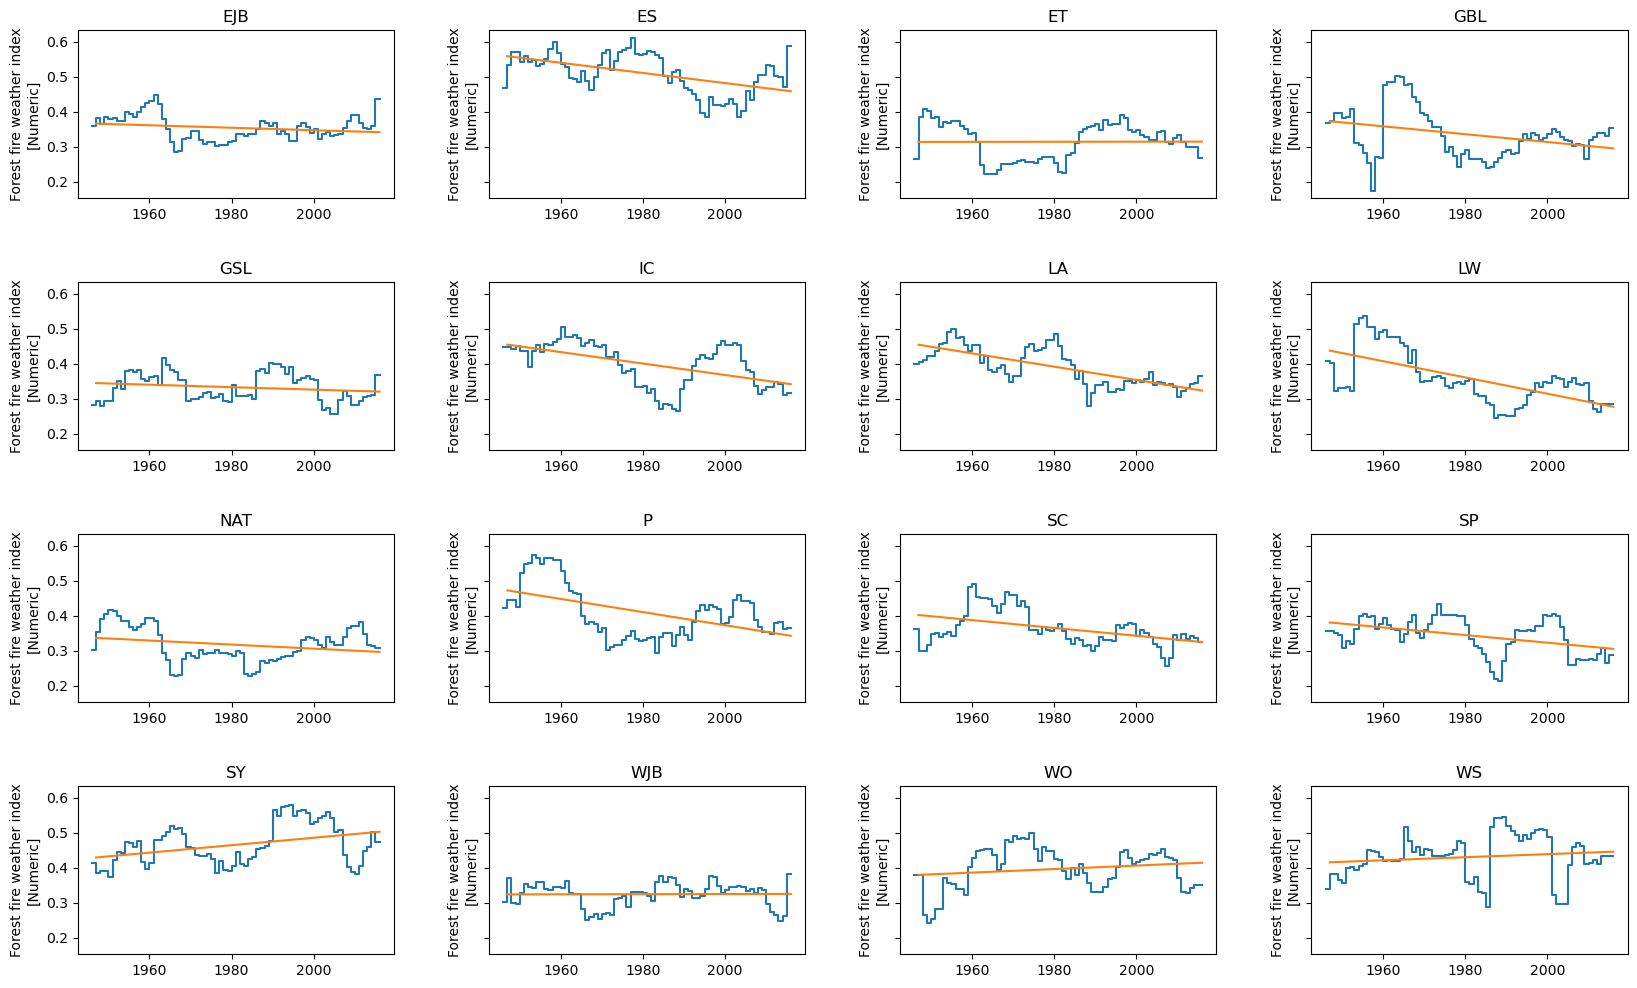

In [415]:
# check running dispersion
fig, axs = plt.subplots(ncols = 4, nrows = 4, figsize = (20,12), dpi = 100, sharey = True)
plt.subplots_adjust(hspace = 0.5, wspace = 0.3)

for i in range(16):
    ax = fig.axes[i]
    cdsr_ts = cdsr.isel(region = i).assign_coords(time = cdsr.time.dt.year)
    cdsr_ts = cdsr_ts.rolling(time = 15, center = True).std() / cdsr_ts.rolling(time = 15, center = True).mean()
    cdsr_ts.plot(ax = ax, drawstyle = "steps")
    
    xyline(cdsr_ts.time.values[7:-7], cdsr_ts.values[7:-7], ax = ax)

    ax.set_title(cdsr_ts.region_name.values)
    ax.set_xlabel("")

In [401]:
xyline(cdsr_ts.time.dt.year.values, cdsr_ts.values, ax = ax)

## **DSR & cumDSR for whole of Canada**

In [ ]:
# get total DSR in each region
cdsr = [((xr.open_dataset(fnm).fwinx ** 1.77) * 0.0272).sum(["latitude", "longitude"]) for fnm in sorted(glob.glob("data/era5_fwi_hfrz-*.nc"))]

# then total DSR over all of Canada
cdsr = xr.concat(cdsr, "region").sum("region")

In [ ]:
cdsr = [((xr.open_dataset(fnm).fwinx ** 1.77) * 0.0272).resample(time = "AS-JAN").sum() for fnm in sorted(glob.glob("data/era5_fwi_hfrz-*.nc"))]

In [9]:
zz = xr.concat(cdsr, "region").sum("region")
zz = zz.where(zz.sum("time") > 0)

In [20]:
zz = zz.stack(xy = ["latitude", "longitude"], create_index = False).dropna("xy", "any").reset_coords(drop = True)
zz.assign_coords(time = zz.time.dt.year).rename(time = "year").to_pandas().to_csv("data/era5_cumDSR_per-grid-cell.csv")

In [15]:
?zz.stack

Signature:
zz.stack(
    dimensions: 'Mapping[Any, Sequence[Hashable]] | None' = None,
    create_index: 'bool | None' = True,
    index_cls: 'type[Index]' = <class 'xarray.core.indexes.PandasMultiIndex'>,
    **dimensions_kwargs: 'Sequence[Hashable]',
) -> 'T_DataArray'
Docstring:
Stack any number of existing dimensions into a single new dimension.

New dimensions will be added at the end, and the corresponding
coordinate variables will be combined into a MultiIndex.

Parameters
----------
dimensions : mapping of Hashable to sequence of Hashable
    Mapping of the form `new_name=(dim1, dim2, ...)`.
    Names of new dimensions, and the existing dimensions that they
    replace. An ellipsis (`...`) will be replaced by all unlisted dimensions.
    Passing a list containing an ellipsis (`stacked_dim=[...]`) will stack over
    all dimensions.
create_index : bool or None, default: True
    If True, create a multi-index for each of the stacked dimensions.
    If False, don't create any inde

In [48]:
cdsr.rename("dsr").to_netcdf("data/era5_dsr_canada-ts.nc")

In [22]:
can_cdsr = xr.concat([cdsr.sel(time = str(y)).cumsum("time") for y in range(1950,2023)], "time")

days = pd.date_range(start = "2020-01-01", end = "2020-12-31")
labelticks = [i+1 for i in range(366) if (days[i].day) == 15]
labels = [days[i].strftime("%b")[:1] for i in range(366) if (days[i].day) == 1]

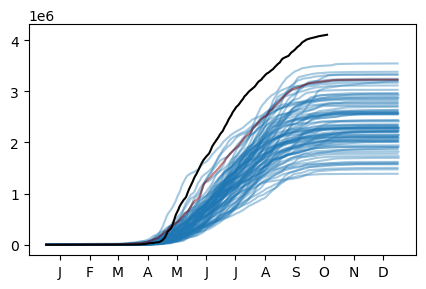

In [24]:
fig, ax = plt.subplots(ncols = 1, nrows = 1, figsize = (5,3), dpi = 100)

for y in range(1941,2022):
    dsr_y = cdsr.sel(time = str(y))
    ax.plot(dsr_y.time.dt.dayofyear, dsr_y.cumsum("time"), color = "tab:blue", alpha = 0.4)

# 95th percentile of cumsum
ax.plot(cdsr.sel(time = "2022").time.dt.dayofyear, can_cdsr.groupby("time.dayofyear").quantile(0.95)[:-1], color = "darkred", alpha = 0.5, label = "95th percentile")

y = 2023
dsr_y = cdsr.sel(time = str(y))
ax.plot(dsr_y.time.dt.dayofyear, dsr_y.cumsum("time"), color = "k", alpha = 1, label = "2023")

ax.set_xticks(labelticks)
ax.set_xticklabels(labels)

plt.savefig("fig/expl_era5_cumDSR-canada.png")

In [5]:
last_day = cdsr.time.max().dt.dayofyear
can_cdsr = cdsr.sel(time = [d <= last_day for d in cdsr.time.dt.dayofyear])      # currently only includes data up to the end of September

In [8]:
can_cdsr = can_cdsr.resample(time = "AS-JAN").sum().where(can_cdsr.sum("time") > 0).rename("cdsr")

In [17]:
can_cdsr.assign_coords(time = can_cdsr.time.dt.year).rename(time = "year").to_dataframe().to_csv("data/era5_cdsr-canada.csv")

In [18]:

zz = xr.open_dataset("data/era5_cumdsr_gridded.nc")
regionmask.defined_regions.natural_earth_v5_0_0.land_110

<regionmask.Regions>
Name:     Natural Earth: landmask 110m
Source:   http://www.naturalearthdata.com
overlap:  False

Regions:
0 lnd land

[1 regions]

## **DSR & FWI daily time series in each HFRZ**

In [25]:
# create data.frame with daily time series for all HFRZs: will use to check extremal dependency in R
ts = xr.concat([xr.open_dataset(fnm).mean(["latitude", "longitude"]) for fnm in glob.glob("data/era5_fwi_hfrz-*.nc")], "region").fwinx

ts = ts.assign_coords(time = ts.time.dt.floor("D"), region = ts.region_name)
ts = ts.sortby(ts.region_name).transpose()
ts.to_pandas().to_csv("data/era5_fwi_daily.csv")

((ts ** 1.77) * 0.0272).to_pandas().to_csv("data/era5_dsr_daily.csv")

# **Normalised DSR**

In [151]:
hfrz_dsr = [((xr.open_dataset(fnm).fwinx ** 1.77) * 0.0272).mean(["latitude", "longitude"]) for fnm in glob.glob("data/era5_fwi_hfrz-*.nc")]
hfrz_dsr = xr.concat(hfrz_dsr, "region").sortby("region_name").resample(time = "AS-JAN").mean()

In [317]:
hfrz_ndsr = (hfrz_dsr - hfrz_dsr.sel(time = slice("1990", "2020")).mean("time")) / hfrz_dsr.sel(time = slice("1990", "2020")).std("time")
hfrz_ndsr = hfrz_ndsr.squeeze().reset_coords(drop = True)#.to_dataframe()

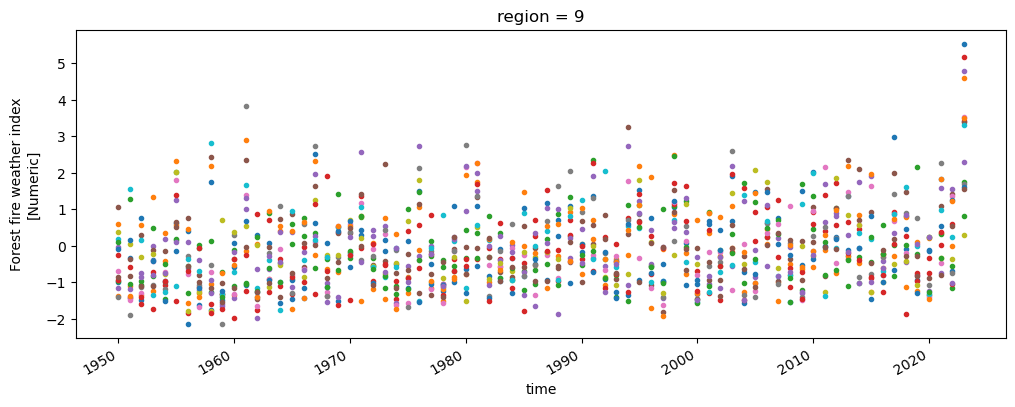

In [329]:
fig, ax = plt.subplots(figsize = (12,4), dpi = 100)
for i in range(16):
    hfrz_ndsr.isel(region = i).sel(time = slice("1950",None)).plot(ax = ax, ls = "", marker = ".")

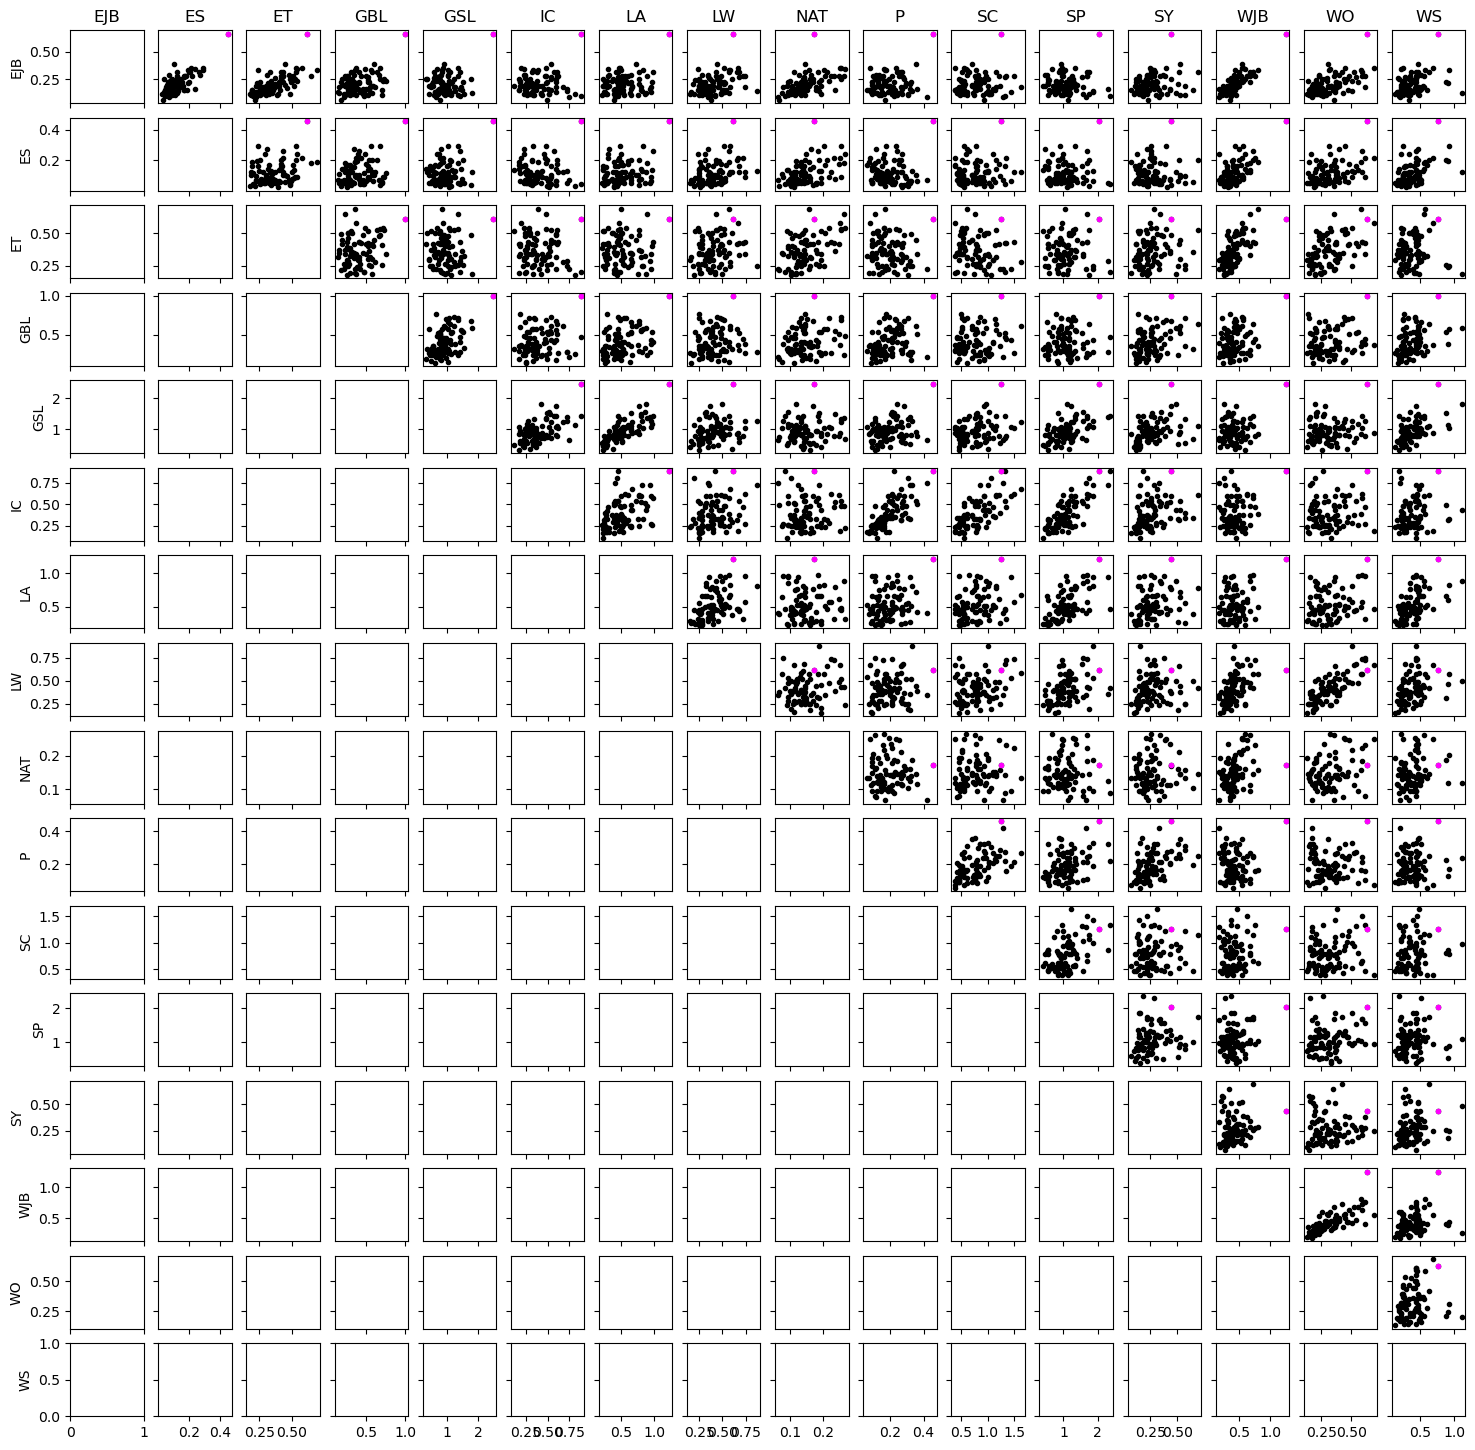

In [358]:
fig, axs = plt.subplots(ncols = 16, nrows = 16, figsize = (18,18), dpi = 100, sharex = "col", sharey = "row")
for i in range(16):
    r = str(hfrz_dsr.region_name[i].values)
    axs[0,i].set_title(r)
    axs[i,0].set_ylabel(r)
    
    if i == 16: continue
    for j in range(i+1,16):
        ax = axs[i,j]
        ax.plot(hfrz_dsr.isel(region = j), hfrz_dsr.isel(region = i), ls = "", marker = ".", color = "k")
        ax.plot(hfrz_dsr.isel(region = j, time = -1), hfrz_dsr.isel(region = i, time = -1), ls = "", marker = ".", color = "magenta")

## **Normalised per HFRZ**

### **Maps of standardised anomaly per HFRZ**

In [151]:
hfrz_dsr = [((xr.open_dataset(fnm).fwinx ** 1.77) * 0.0272).mean(["latitude", "longitude"]) for fnm in glob.glob("data/era5_fwi_hfrz-*.nc")]
hfrz_dsr = xr.concat(hfrz_dsr, "region").sortby("region_name").resample(time = "AS-JAN").mean()

In [162]:
dsr_2023 = (hfrz_dsr.sel(time = "2023") - hfrz_dsr.sel(time = slice("1990", "2020")).mean("time")) / hfrz_dsr.sel(time = slice("1990", "2020")).std("time")
dsr_2023 = dsr_2023.squeeze().reset_coords(drop = True).to_dataframe()

In [188]:
hfrz_2023 = pd.merge(hfrz, dsr_2023, left_index = True, right_index = True)

In [198]:
fig, ax = plt.subplots(subplot_kw = {"projection" : cproj}, dpi = 100)
hfrz_2023.plot(column = "fwinx", ax = ax, legend = True)

In [212]:
hfrz_2023["log_rp"] = 1/norm.sf(np.log(hfrz_2023.fwinx))

Text(0.5, 1.0, '2023 return period (ish)')

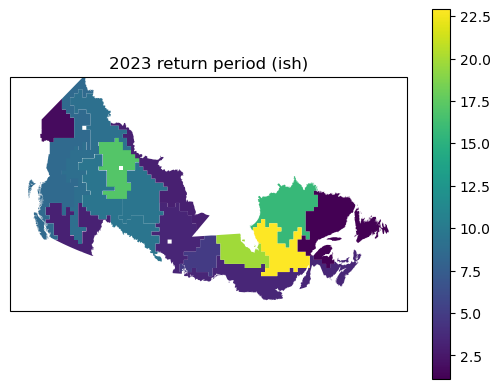

In [215]:
fig, ax = plt.subplots(subplot_kw = {"projection" : cproj}, dpi = 100)
hfrz_2023.plot(column = "log_rp", ax = ax, legend = True)
ax.set_title("2023 return period (ish)")

## **Normalised per grid cell**

In [121]:
fwi = xr.concat([xr.open_dataset(fnm).sel(time = "2023") for fnm in glob.glob("data/era5_fwi_hfrz-*.nc")], "region").fwinx
fwi = fwi.assign_coords({k : (["latitude", "longitude"], v)  for k,v in zip(["x","y"], latlon_to_lambert(fwi.isel(time = 0, region = 0)))})

dsr = (fwi ** 1.77) * 0.0272
cumdsr = dsr.mean(["region", "time"]).where(dsr.sum(["region", "time"]) > 0)

# normalise wrt 1990-2020 climatology
ref_dsr = xr.open_dataset("data/era5_dsr-ref_annual-mean-sd.nc")
ndsr = (cumdsr - ref_dsr.dsr_mean) / ref_dsr.dsr_sd

### **Maps of standardised anomaly per grid cell**

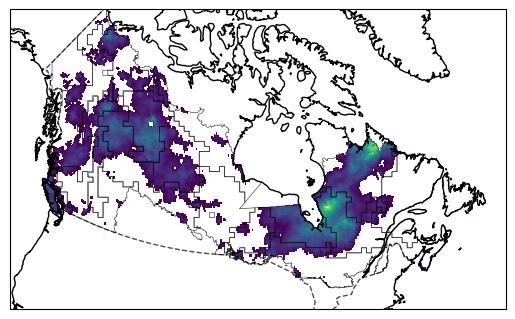

In [312]:
fig, ax = plt.subplots(subplot_kw = {"projection" : cproj}, dpi = 100)
cbar = ax.pcolormesh(ndsr.x, ndsr.y, ndsr.where(ndsr > norm.ppf(0.975)))
ax.coastlines()
hfrz.boundary.plot(ax = ax, color = "k", lw = 0.5, alpha = 0.7)
ax.add_feature(cartopy.feature.BORDERS, color = "k", alpha = 0.7, ls = "--")

In [140]:
fig, ax = plt.subplots(subplot_kw = {"projection" : cproj}, dpi = 100)
cbar = ax.pcolormesh(ndsr.x, ndsr.y, ndsr.where(ndsr > norm.ppf(0.975)))
ax.coastlines()
hfrz.boundary.plot(ax = ax, color = "k", lw = 0.5, alpha = 0.7)
ax.add_feature(cartopy.feature.BORDERS, color = "k", alpha = 0.7, ls = "--")

# **MODIS active fire data**


## **Add regions to active fire data**

In [21]:
# # load all fire data
# modis = pd.concat([pd.read_csv(fnm) for fnm in glob.glob("data/fire_*_M-C61_*.csv")])

# # convert to geodataframe (standard lat-lon coords) & reproject geometry
# modis = gpd.GeoDataFrame(modis, geometry = gpd.points_from_xy(x=modis.longitude, y=modis.latitude), crs = "EPSG:4326")
# modis = modis.to_crs(cproj)

# # add year & month as columns for easier filtering
# modis["y"] = [int(d[:4]) for d in modis.acq_date]
# modis["m"] = [int(d[5:7]) for d in modis.acq_date]

# # assign each point to a fire region - takes ages so only doing this once! 
# zz = gpd.overlay(modis, hfrz.to_crs(epsg = 4326), how='intersection')

# # save as .csv (can restore geometry later) - also filter out partial year in 2000
# zz.loc[zz.y > 2000].iloc[:,:-1].to_csv("data/modis-active-fires-with-hfrz.csv", index = False)

## **Maps of occurrences**

In [3]:
modis = pd.read_csv("data/modis-active-fires-with-hfrz.csv", parse_dates = ["acq_date"], index_col = "acq_date")
modis = gpd.GeoDataFrame(modis, geometry = gpd.points_from_xy(x=modis.longitude, y=modis.latitude), crs = "EPSG:4326")
modis = modis.to_crs(cproj)

In [9]:
provinces = gpd.read_file("sf_firerisk")

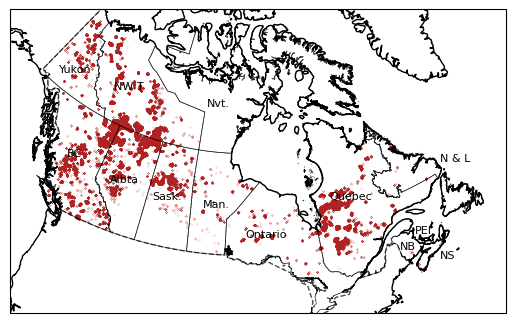

In [12]:
fig, ax = plt.subplots(subplot_kw = {"projection" : cproj}, dpi = 100)

modis.loc[modis.y == 2023].plot(ax = ax, marker = ".", color = "firebrick", alpha = 0.7, markersize = 0.1)
ax.coastlines()
# hfrz.boundary.plot(ax = ax, color = "k", lw = 0.5, alpha = 0.7)
# [ax.annotate(k, xy = v, fontsize = 8) for k, v in hfrz_px.items()]

provinces.boundary.plot(ax = ax, color = "k", lw = 0.5, alpha = 0.7)
[ax.annotate(k, xy = v, fontsize = 8) for k, v in province_px.items()]

ax.add_feature(cartopy.feature.BORDERS, color = "k", alpha = 0.7, ls = "--")
plt.savefig("fig/expl_modis-active-fires-2023.png")

## **Correlation between annual DSR and MODIS active fires**

In [272]:
ycounts = modis.groupby("NAMES_SHOR").resample("AS-JAN").count()[["y"]]
dsr = xr.open_dataset("data/era5_dsr_hfrz-ts.nc").dsr.resample(time = "AS-JAN").sum()
ydsr = dsr.assign_coords(region = dsr.region_name).rename(region = "NAMES_SHOR", time = "acq_date").reset_coords(drop = True).to_dataframe()

df = pd.merge(ycounts.reset_index(), ydsr.reset_index(), on = ["NAMES_SHOR", "acq_date"]).set_index(["NAMES_SHOR"])
ycorr = pd.DataFrame.from_dict({"ycorr" : {r : np.corrcoef(df.loc[(r), "y"], df.loc[(r), "dsr"])[0,1] for r in dsr.region_name.values}})

## **Correlation between MDSR and MODIS active fires**

In [273]:
mcounts = modis.groupby("NAMES_SHOR").resample("MS").count()[["y"]]

In [274]:
dsr = xr.open_dataset("data/era5_dsr_hfrz-ts.nc").dsr.resample(time = "MS").sum()
mdsr = dsr.assign_coords(region = dsr.region_name).rename(region = "NAMES_SHOR", time = "acq_date").reset_coords(drop = True).to_dataframe()

In [443]:
# df = pd.merge(mcounts, cdsr, left_index = True, right_index = True)
df = pd.merge(mcounts.reset_index(), mdsr.reset_index(), on = ["NAMES_SHOR", "acq_date"])
df["m"] = [d.month for d in df.acq_date]
df = df.set_index(["NAMES_SHOR", "m"])
df["y"] = df["y"] + 1  # dummy pixel to avoid infinite values when taking logs etc

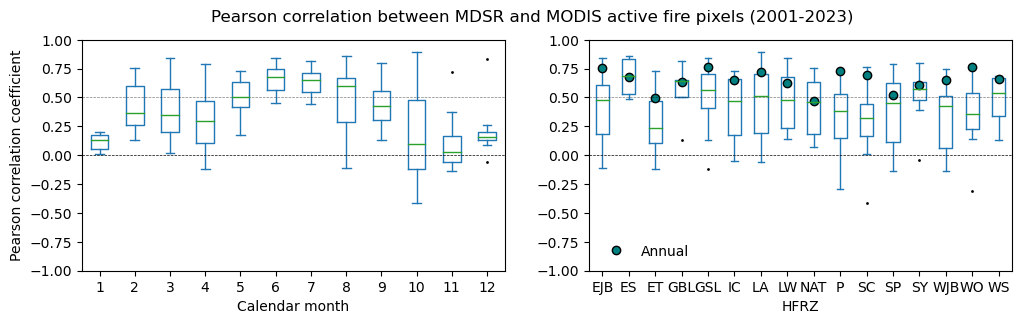

In [444]:
# plot Pearson correlations in each month over all HFRZs
pcorr = pd.DataFrame({r : {m+1 : np.corrcoef(df.loc[(r, m+1), "y"], df.loc[(r, m+1), "dsr"])[0,1] for m in range(12)} for r in dsr.region_name.values})
boxplot_kwargs = {"flierprops" : {"marker" : "o", "markersize" : 1, "color" : "tab:blue"}}

fig, axs = plt.subplots(ncols = 2, figsize = (12,3), dpi = 100, facecolor = "w")

ax = axs[0]
pcorr.transpose().plot(ax = ax, kind = "box", ylim = [-1,1], **boxplot_kwargs)
ax.set_ylabel("Pearson correlation coefficient")
ax.set_xlabel("Calendar month")

ax = axs[1]
pcorr.plot(ax = ax, kind = "box", ylim = [-1,1], **boxplot_kwargs)
ax.plot(range(len(ycorr)+1)[1:], ycorr, ls = "", marker = "o", mec = "k", label = "Annual", c = "teal")
ax.set_xlabel("HFRZ")
ax.legend(edgecolor = "w")

for ax in axs:
    ax.axhline(0, color = "k", lw = 0.5, ls = "--")
    ax.axhline(0.5, color = "k", lw = 0.5, ls = "--", alpha = 0.5)
    
plt.suptitle("Pearson correlation between MDSR and MODIS active fire pixels (2001-2023)")

plt.savefig("fig/expl_mdsr-modis-correlation.png")

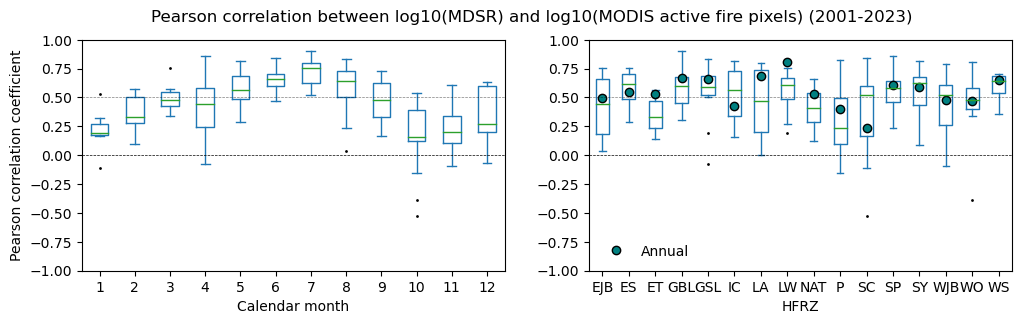

In [446]:
ycorr_log10 = pd.DataFrame.from_dict({"ycorr" : {r : np.corrcoef(np.log10(df.loc[(r), "y"]), np.log10(df.loc[(r), "dsr"]))[0,1] for r in dsr.region_name.values}})

pcorr_log10 = pd.DataFrame({r : {m+1 : np.corrcoef(np.log10(df.loc[(r, m+1), "y"]), np.log10(df.loc[(r, m+1), "dsr"]))[0,1] for m in range(12)} for r in dsr.region_name.values})
boxplot_kwargs = {"flierprops" : {"marker" : "o", "markersize" : 1, "color" : "tab:blue"}}

fig, axs = plt.subplots(ncols = 2, figsize = (12,3), dpi = 100, facecolor = "w")

ax = axs[0]
pcorr_log10.transpose().plot(ax = ax, kind = "box", ylim = [-1,1], **boxplot_kwargs)
ax.set_ylabel("Pearson correlation coefficient")
ax.set_xlabel("Calendar month")

ax = axs[1]
pcorr_log10.plot(ax = ax, kind = "box", ylim = [-1,1], **boxplot_kwargs)
ax.plot(range(len(ycorr_log10)+1)[1:], ycorr_log10, ls = "", marker = "o", mec = "k", label = "Annual", c = "teal")
ax.set_xlabel("HFRZ")
ax.legend(edgecolor = "w")

for ax in axs:
    ax.axhline(0, color = "k", lw = 0.5, ls = "--")
    ax.axhline(0.5, color = "k", lw = 0.5, ls = "--", alpha = 0.5)
    
plt.suptitle("Pearson correlation between log10(MDSR) and log10(MODIS active fire pixels) (2001-2023)")

plt.savefig("fig/expl_mdsr-modis-correlation_log10MDSR.png")

Text(0.5, 0.98, 'Spearman rank correlation between MDSR and MODIS active fire pixels (2001-2023)')

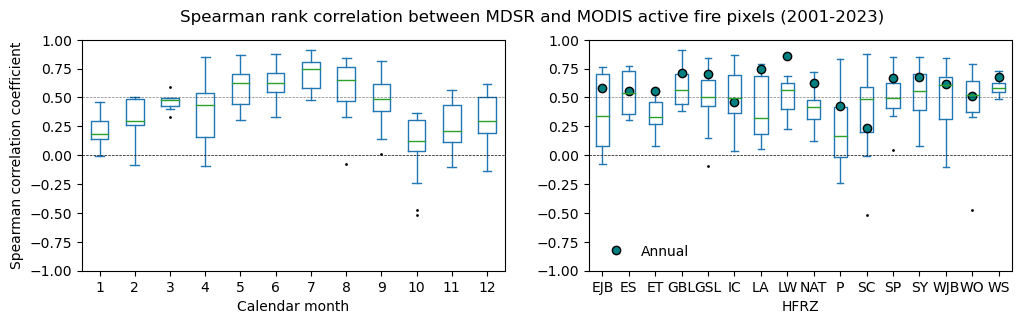

In [459]:
# plot Spearman correlations in each month over all HFRZs
yscorr = pd.DataFrame.from_dict({"ycorr" : {r : spearmanr(df.loc[(r), "y"], df.loc[(r), "dsr"])[0] for r in dsr.region_name.values}})
scorr = pd.DataFrame({r : {m+1 : spearmanr(df.loc[(r, m+1), "y"].values, df.loc[(r, m+1), "dsr"].values)[0] for m in range(12)} for r in dsr.region_name.values})
boxplot_kwargs = {"flierprops" : {"marker" : "o", "markersize" : 1, "color" : "tab:blue"}}

fig, axs = plt.subplots(ncols = 2, figsize = (12,3), dpi = 100, facecolor = "w")

ax = axs[0]
scorr.transpose().plot(ax = ax, kind = "box", ylim = [-1,1], **boxplot_kwargs)
ax.set_ylabel("Spearman correlation coefficient")
ax.set_xlabel("Calendar month")

ax = axs[1]
scorr.plot(ax = ax, kind = "box", ylim = [-1,1], **boxplot_kwargs)
ax.plot(range(len(yscorr)+1)[1:], yscorr, ls = "", marker = "o", mec = "k", label = "Annual", c = "teal")
ax.set_xlabel("HFRZ")
ax.legend(edgecolor = "w")

for ax in axs:
    ax.axhline(0, color = "k", lw = 0.5, ls = "--")
    ax.axhline(0.5, color = "k", lw = 0.5, ls = "--", alpha = 0.5)
    
plt.suptitle("Spearman rank correlation between MDSR and MODIS active fire pixels (2001-2023)")

# plt.savefig("fig/expl_mdsr-modis-correlation.png")

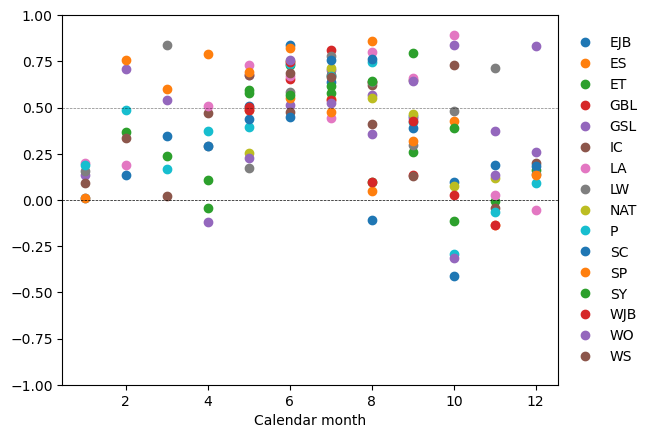

In [277]:
fig = pcorr.plot(ls = "", marker = "o")
fig.legend(loc = "center left", bbox_to_anchor = (1,0.5), edgecolor = "w")
plt.xlabel("Calendar month") 
plt.ylim(-1,1)
plt.axhline(0, color = "k", lw = 0.5, ls = "--")
plt.axhline(0.5, color = "k", lw = 0.5, ls = "--", alpha = 0.5)

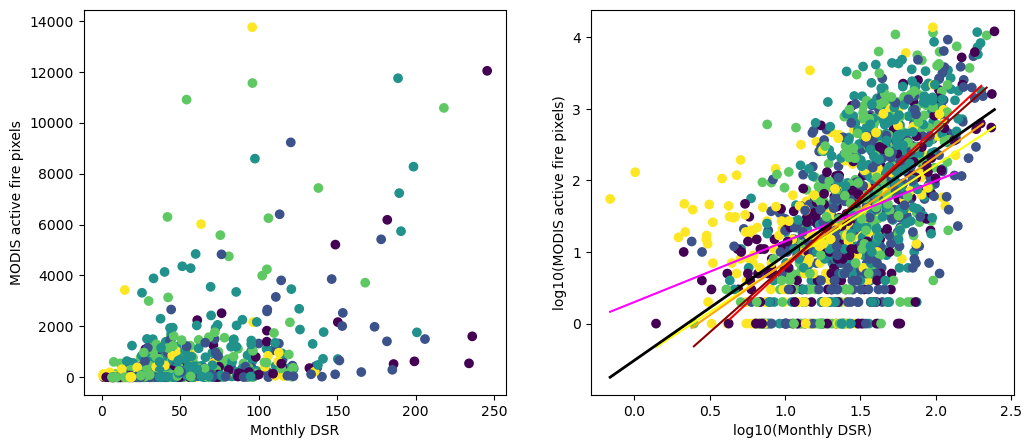

In [355]:
dff = df.reset_index()
dff = dff.loc[dff.y > 0]
dff = dff.loc[[m in [5,6,7,8,9] for m in dff.m]]

fig, axs = plt.subplots(ncols = 2, figsize = (12,5), dpi = 100, facecolor = "w")

plot_kwargs = {"c" : dff.m}

ax = axs[0]
ax.scatter((dff.dsr),(dff.y), **plot_kwargs)
ax.set_xlabel("Monthly DSR")
ax.set_ylabel("MODIS active fire pixels")

ax = axs[1]
ax.scatter(np.log10(dff.dsr), np.log10(dff.y), **plot_kwargs)
ax.set_xlabel("log10(Monthly DSR)")
ax.set_ylabel("log10(MODIS active fire pixels)")

xyline(np.log10(dff.loc[dff.m == 5].dsr), np.log10(dff.loc[dff.m == 5].y), ax = ax, color = "yellow")
xyline(np.log10(dff.loc[dff.m == 6].dsr), np.log10(dff.loc[dff.m == 6].y), ax = ax, color = "orange")
xyline(np.log10(dff.loc[dff.m == 7].dsr), np.log10(dff.loc[dff.m == 7].y), ax = ax, color = "red")
xyline(np.log10(dff.loc[dff.m == 8].dsr), np.log10(dff.loc[dff.m == 8].y), ax = ax, color = "darkred")
xyline(np.log10(dff.loc[dff.m == 9].dsr), np.log10(dff.loc[dff.m == 9].y), ax = ax, color = "magenta")

xyline(np.log10(dff.dsr), np.log10(dff.y), ax = ax, color = "k", lw = 2)


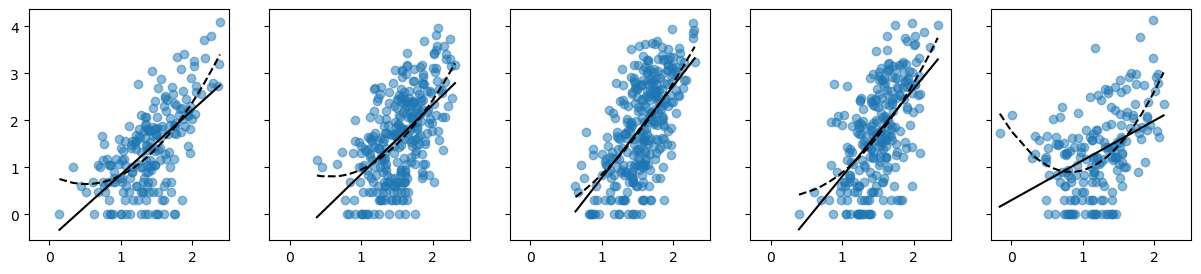

In [374]:
# quick investigation of relationship between monthly DSR and monthly active fire area
fig, axs = plt.subplots(ncols = 5, figsize = (15,3), dpi = 100, facecolor = "w", sharex = True, sharey = True)

for i in range(5):
    ax = axs[i]
    m = range(5,10)[i]
    
    x = np.log10(dff.loc[dff.m == m].dsr)
    y = np.log10(dff.loc[dff.m == m].y)
    
    # ax.set_title(np.corrcoef(x,y)[0,1])
    
    ax.scatter(x,y, alpha = 0.5)
    xyline(x,y,npoly = 1, ax = ax, color = "k")
    xyline(x,y,npoly = 2, ax = ax, ls = "--", color = "k")


---
# **Positive pressure anomalies**

In [16]:
fwi = xr.concat([xr.open_dataset(fnm).sel(time = "2023") for fnm in glob.glob("data/era5_fwi_hfrz-*.nc")], "region").fwinx
fwi = fwi.assign_coords({k : (["latitude", "longitude"], v)  for k,v in zip(["x","y"], latlon_to_lambert(fwi.isel(time = 0, region = 0)))})
dsr = ((fwi ** 1.77) * 0.0272).sum("region")
dsr = dsr.where(dsr > 0)

ppa = xr.open_dataset("ppa/PPA_mask_2023.nc").z
ppa = ppa.assign_coords({k : (["latitude", "longitude"], v)  for k,v in zip(["x","y"], latlon_to_lambert(ppa.isel(time = 0)))})
ppa = ppa.where(ppa == 1)

In [40]:
df = pd.read_csv("data/output_dataframe_extended_1950-2023.csv", index_col = "date", parse_dates = ["date"])
df = gpd.GeoDataFrame(df, geometry = gpd.points_from_xy(df.lon, df.lat))
df = df.set_crs(epsg = 4326).to_crs(epsg = 3347)

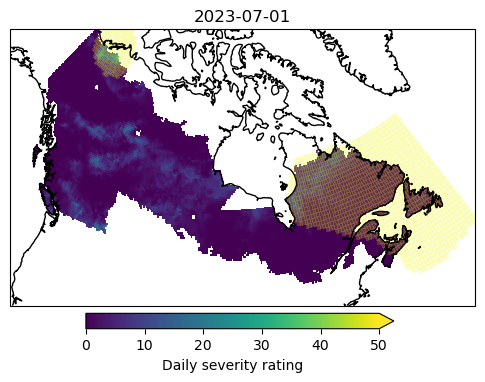

In [70]:
fig, ax = plt.subplots(dpi = 100, figsize = (6,4), subplot_kw = {"projection" : cproj})
t = "2023-07-01"

cbar = ax.pcolormesh(dsr.x, dsr.y, dsr.sel(time = t).squeeze(drop = True), vmin = 0, vmax = 50)
ax.pcolormesh(ppa.x, ppa.y, ppa.sel(time = t), alpha = 0.2, cmap = "plasma_r")
ax.coastlines()
plt.colorbar(cbar, location = "bottom", pad = 0.025, fraction = 0.05, shrink = 0.9, label = "Daily severity rating", extend = "max")
ax.set_title(t)

if t in df.index:
    df.loc[[t]].plot(ax = ax, color = "orange", edgecolor = "k")

## **Animated maps of PPA & DSR**

In [72]:
from PIL import Image
import glob
import re

# method to create GIF from individual images
def make_gif(img_pattern, gif_name = "new_gif", frame_dur = 4, nloops = 0):
    
    gif_name = re.sub("\.gif", "", gif_name)+".gif"
    img_list = sorted(glob.glob(img_pattern))
    frames = [Image.open(image) for image in img_list]
    frame_one = frames[0]
    frame_one.save(gif_name, format="GIF", append_images = frames, save_all = True, duration = len(img_list) * frame_dur, loop=nloops)

In [73]:
# load Lambert coordinates for quicker plotting
fwi_xy = xr.concat([xr.open_dataset(fnm).isel(time = 0, drop = True) for fnm in glob.glob("data/era5_fwi_hfrz-*.nc")], "region").fwinx.sum("region")
fwi_xy = fwi_xy.assign_coords({k : (["latitude", "longitude"], v)  for k,v in zip(["x","y"], latlon_to_lambert(fwi_xy))})

ppa_xy = xr.open_dataset("ppa/PPA_mask_2023.nc").z.isel(time = 0, drop = True)
ppa_xy = ppa_xy.assign_coords({k : (["latitude", "longitude"], v)  for k,v in zip(["x","y"], latlon_to_lambert(ppa_xy))})

In [110]:
for y in range(2023, 2024):
    
    # load FWI, calculate DSR
    fwi = xr.concat([xr.open_dataset(fnm).sel(time = slice(str(y)+"-04", str(y)+"-10")) for fnm in glob.glob("data/era5_fwi_hfrz-*.nc")], "region").fwinx.sum("region")
    dsr = ((fwi ** 1.77) * 0.0272)
    dsr = dsr.assign_coords(time = dsr.time.dt.floor(freq = "D"))
    dsr = dsr.where(dsr > 0)
    
    # load PPA and ensure that dates match 
    ppa = xr.open_dataset("ppa/PPA_mask_"+str(y)+".nc").z
    ppa = ppa.sel(time = dsr.time)
    ppa = ppa.where(ppa > 0)
    
    # create individual plots for animation
    for t in dsr.time:
        img_fnm = "ppa_img/ppa-dsr_"+str(t.dt.date.values)+".png"
        if os.path.exists(img_fnm): continue
        fig, ax = plt.subplots(dpi = 100, figsize = (6,4), subplot_kw = {"projection" : cproj})
        
        cbar = ax.pcolormesh(fwi_xy.x, fwi_xy.y, dsr.sel(time = t), vmin = 0, vmax = 50)
        ax.pcolormesh(ppa_xy.x, ppa_xy.y, ppa.sel(time = t), alpha = 0.2, cmap = "plasma_r")
        ax.coastlines()
        plt.colorbar(cbar, location = "bottom", pad = 0.025, fraction = 0.05, shrink = 0.9, label = "Daily severity rating", extend = "max")
        ax.set_title(t.dt.date.values)
        
        # plot centres of blocking patterns identified by Philippe & Clemence
        if str(t.dt.strftime("%Y-%m-%d").values) in df.index:
            df.loc[[str(t.dt.strftime("%Y-%m-%d").values)]].plot(ax = ax, color = "orange", edgecolor = "k")

        plt.suptitle("DSR vs persistent positive anomalies - "+str(y), fontweight = "bold")
        plt.savefig(img_fnm); plt.close()

In [6]:
# compile into single gif
for y in list(set([fnm.split("_")[-1][:4] for fnm in glob.glob("ppa_img/*.png")])):
    gif_fnm = "gifs/ppa-dsr-"+y+".gif"
    if os.path.exists(gif_fnm): continue
    make_gif("ppa_img/ppa-dsr_"+y+"*.png", gif_name = gif_fnm, frame_dur = 1, nloops = 1)

## **Correlation between PPA & DSR**

In [158]:
ppa = xr.open_mfdataset("ppa/PPA_mask_*.nc").z.sel(time = slice(None, "2023-10-19"))
corrs = []

for fnm in glob.glob("data/era5_fwi_hfrz-*.nc"):
    fwi = xr.open_dataset(fnm).fwinx
    dsr = (fwi ** 1.77) * 0.0272
    dsr = dsr.assign_coords(time = dsr.time.dt.floor("D"))
    dsr = dsr.sel(time = ppa.time)
    pc = xr.corr(dsr, ppa, "time").assign_coords(region = dsr.region).expand_dims("region").rename("ppa_dsr_corr")
    corrs.append(pc)
corrs = xr.concat(corrs, "region").sum("region")

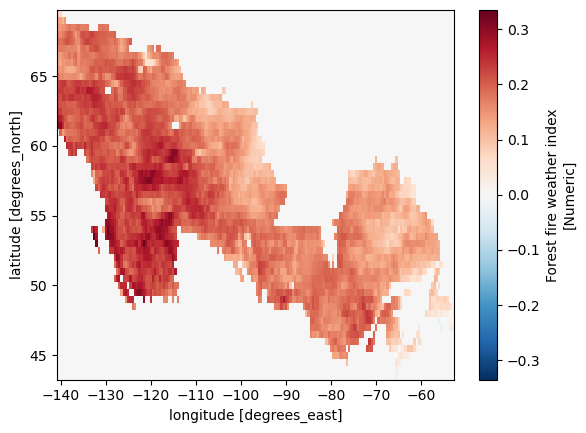

In [164]:
# Pearson correlation between daily PPA and daily severity
corrs.plot()

## **Time series of PPA per HFRZ**
- lagged correlations? Or just look at the annual total? (Think this is cleaner)
- include PPA as covariate in predictive model

In [2]:
# ppa = xr.open_dataset("ppa/PPA_mask_2023.nc").z
# rm_ppa = regionmask.mask_3D_geopandas(hfrz.to_crs(epsg = 4326), ppa.longitude, ppa.latitude)
# ppa_ts = xr.concat([xr.open_dataset(fnm).where(rm_ppa == 1).mean(["latitude", "longitude"]) for fnm in glob.glob("ppa/PPA_mask_*.nc")], "time").sortby("time").rename(z = "ppa")
# ppa_ts = ppa_ts.assign_coords(region_name = ("region", hfrz.NAMES_SHOR))
# ppa_ts.to_netcdf("data/ppa_hfrz-ts.nc")

In [41]:
# ppa = xr.open_dataset("ppa/PPA_mask_2023.nc").z
# canada = regionmask.defined_regions.natural_earth_v5_0_0.countries_50.mask_3D(ppa.longitude, ppa.latitude).sel(region = 202)
# canada_ts = xr.concat([xr.open_dataset(fnm).where(canada == 1).mean(["latitude", "longitude"]) for fnm in glob.glob("ppa/PPA_mask_*.nc")], "time").sortby("time").rename(z = "ppa").reset_coords(drop = True)
# canada_ts.to_netcdf("data/ppa_canada-ts.nc")

### **2023 PPA & DSR**

#### **Canada**

In [74]:
ppa_ts = xr.open_dataset("data/ppa_canada-ts.nc").ppa.sel(time = "2023")

In [71]:
# load DSR, normalise each grid cell to have mean 0, variance 1
dsr = xr.open_dataset("data/era5_dsr_2020-2023.nc").dsr.sel(time = slice("2023-04-01", "2023-10-31"))
canada = regionmask.defined_regions.natural_earth_v5_0_0.countries_50.mask_3D(dsr.longitude, dsr.latitude).sel(region = 202)
dsr = dsr.where(canada == 1)

In [85]:
dsr_ref = xr.open_dataset("data/era5_dsr-ref_daily-mean-sd.nc")
dsr_n = ((dsr) / dsr_ref.dsr_sd).mean(["latitude", "longitude"])

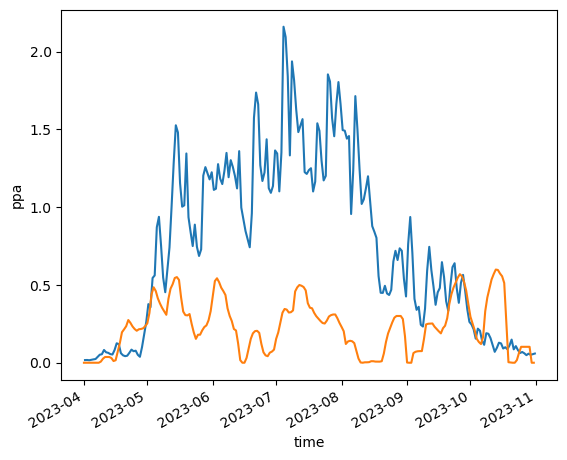

In [86]:
dsr_n.plot()
ppa_ts.plot()

#### **By HFRZ**

In [9]:
dsr_ts = xr.open_dataset("data/era5_dsr_hfrz-ts.nc").sortby("region_name").dsr
ppa_ts = xr.open_dataset("data/ppa_hfrz-ts.nc").sortby("region_name").ppa

# align timestamps & trim to same duration
dsr_ts = dsr_ts.assign_coords(time = dsr_ts.time.dt.floor(freq = "D"))
ppa_ts = ppa_ts.sel(time = slice(None, dsr_ts.time.max()))
dsr_ts = dsr_ts.sel(time = ppa_ts.time).transpose()

dsr_n = (dsr_ts) / dsr_ts.sel(time = "2023").std("time")

In [10]:
dsr_ts = dsr_ts.assign_coords(region = range(0,16))

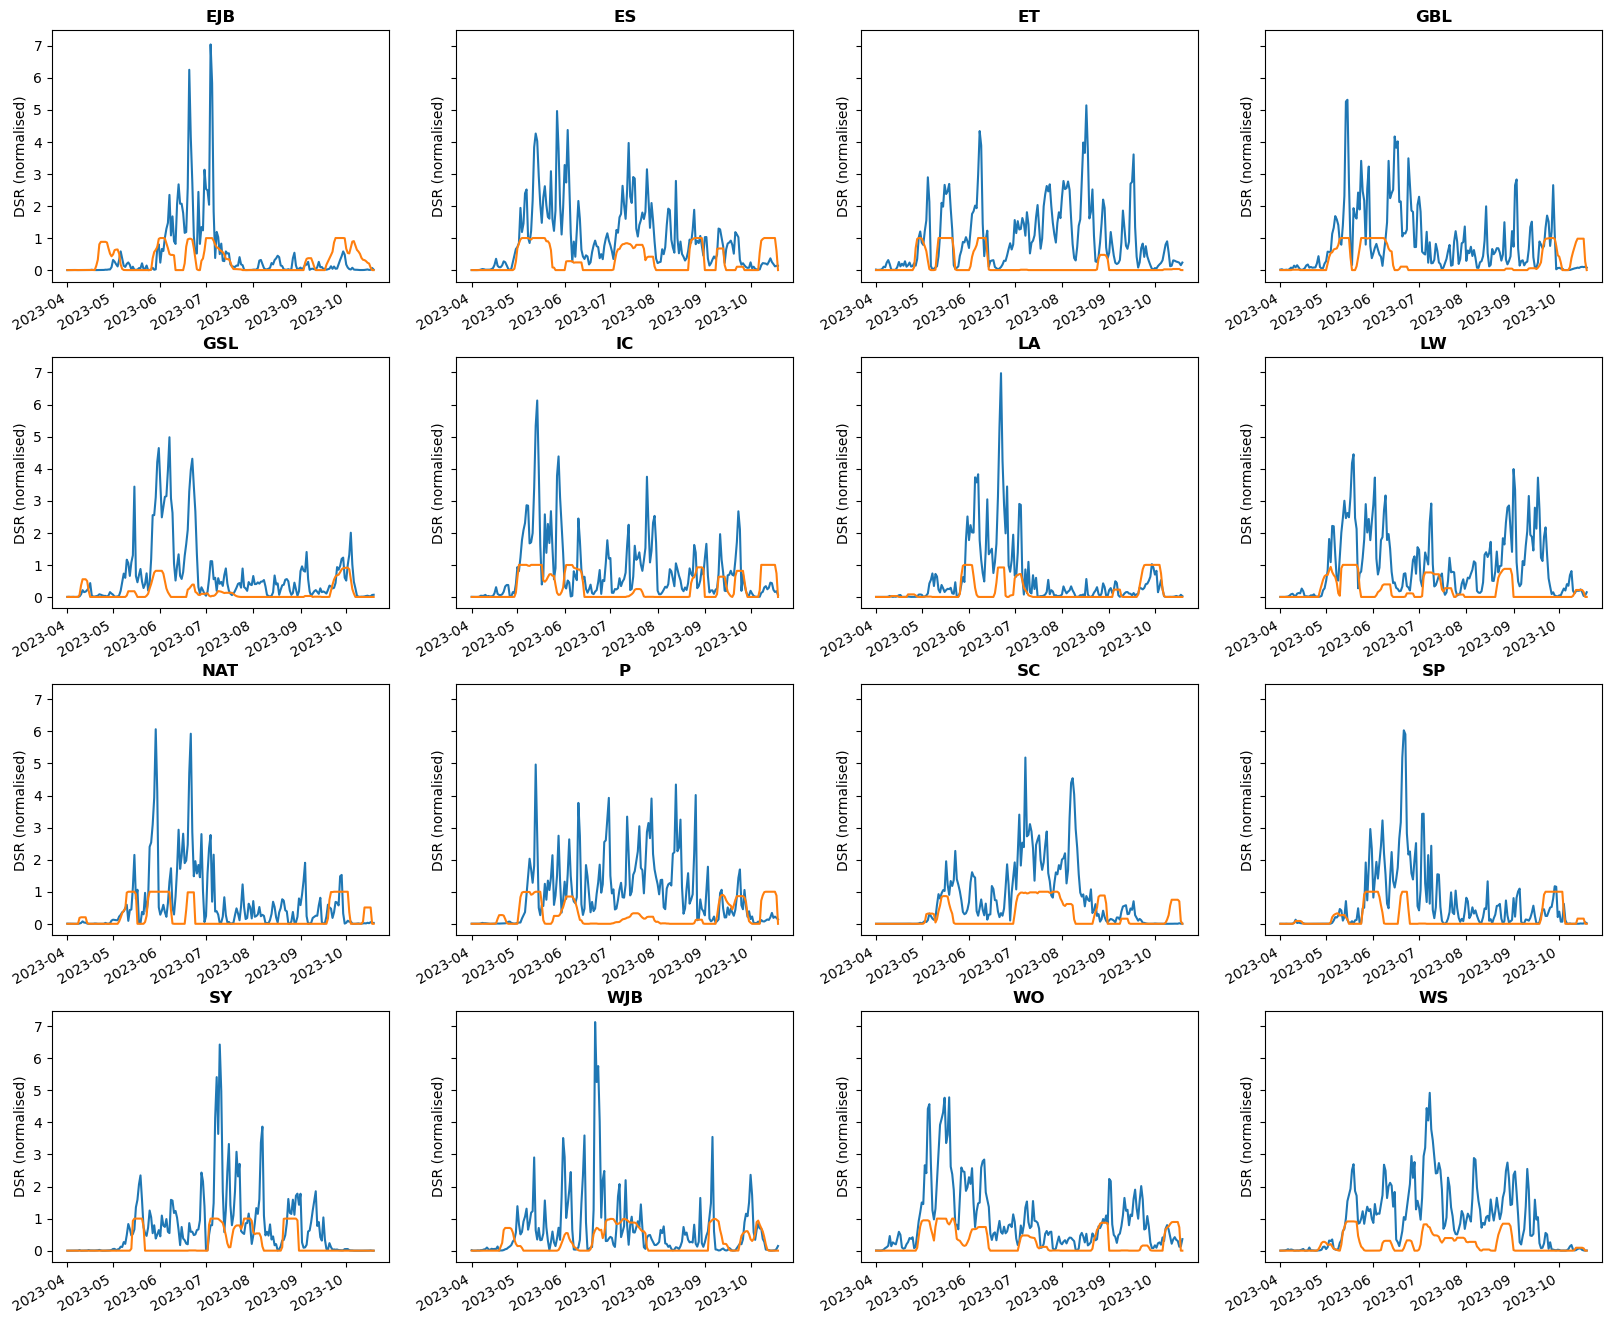

In [11]:
fig, axs = plt.subplots(ncols = 4, nrows = 4, figsize = (20,16), sharey = True)
plt.subplots_adjust(hspace = 0.3)

for i in range(16):
    ax = fig.axes[i]
    dsr_n.sel(region = i, time = "2023").plot(ax = ax)
    ppa_ts.sel(region = i, time = "2023").plot(ax = ax)
    
    ax.set_title(str(dsr_ts.sel(region = i).region_name.values), fontweight = "bold")
    ax.set_xlabel("")
    ax.set_ylabel("DSR (normalised)")

### **Annual PPA vs DSR**

In [13]:
dsr_ts = xr.open_dataset("data/era5_dsr_hfrz-ts.nc").sortby("region_name").dsr
ppa_ts = xr.open_dataset("data/ppa_hfrz-ts.nc").ppa.sortby("region_name")

# align timestamps & trim to same duration
dsr_ts = dsr_ts.assign_coords(time = dsr_ts.time.dt.floor(freq = "D"))
ppa_ts = ppa_ts.sel(time = slice(None, dsr_ts.time.max()))
dsr_ts = dsr_ts.sel(time = ppa_ts.time).transpose()

In [14]:
ppa_ann = ppa_ts.resample(time = "AS-JAN").mean()
dsr_ann = dsr_ts.resample(time = "AS-JAN").mean()

ppa_ann = (ppa_ann - ppa_ann.mean("time")) / ppa_ann.std("time")
dsr_ann = (dsr_ann - dsr_ann.mean("time")) / dsr_ann.std("time")

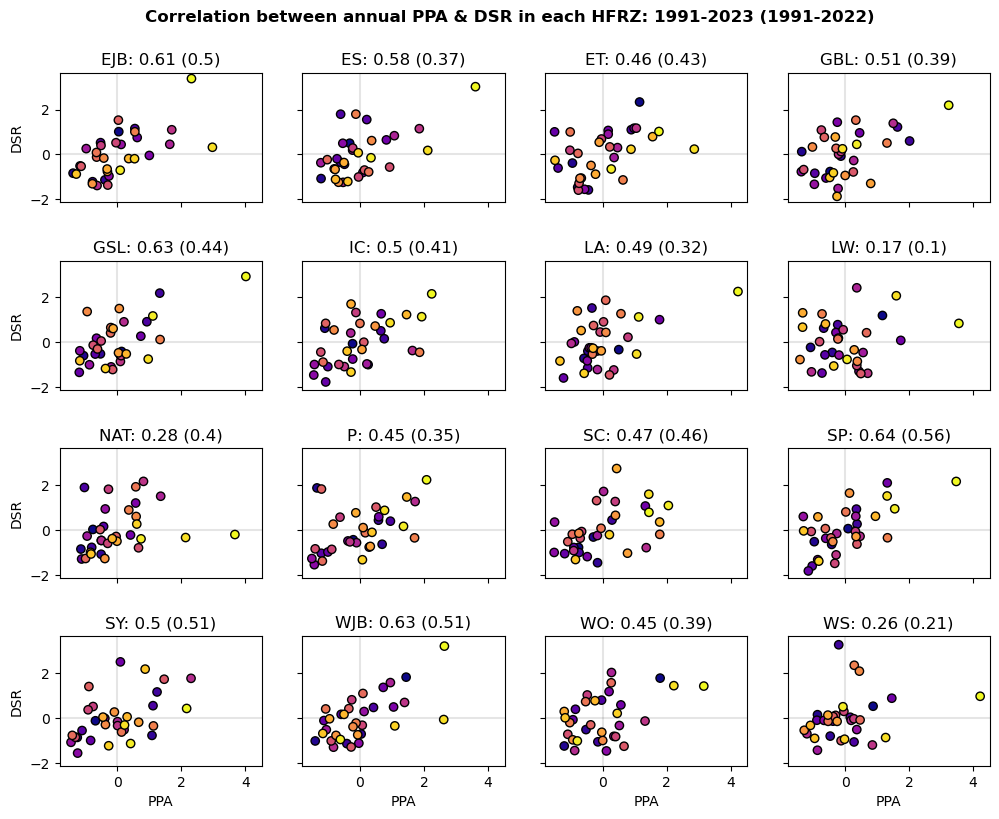

In [19]:
fig, axs = plt.subplots(ncols = 4, nrows = 4, figsize = (12,9), sharey = True, sharex = True)
plt.subplots_adjust(hspace = 0.45)

for i in range(16):
    ax = fig.axes[i]
    ppa_r = ppa_ann.isel(region = i)
    dsr_r = dsr_ann.isel(region = i)
    ax.scatter(ppa_r, dsr_r, c = ppa_r.time.dt.year, edgecolor = "k", cmap = "plasma")
    corr_all = np.corrcoef(ppa_r, dsr_r)[0,1]
    corr_excl_2023 = np.corrcoef(ppa_r.sel(time = slice(None, "2022")), dsr_r.sel(time = slice(None, "2022")))[0,1]
    ax.set_title(str(dsr_r.region_name.values)+": "+str(round(corr_all, 2))+" ("+str(round(corr_excl_2023, 2))+")")
    
    ax.axhline(0, color = "k", alpha = 0.1, zorder = -9)
    ax.axvline(0, color = "k", alpha = 0.1, zorder = -9)

for ax in axs[-1,:]: ax.set_xlabel("PPA")
for ax in axs[:,0]: ax.set_ylabel("DSR")

plt.suptitle("Correlation between annual PPA & DSR in each HFRZ: 1991-2023 (1991-2022)", y = 0.95, fontweight = "bold")
plt.savefig("fig/ppa-dsr_annual-ts-correlation.png")

---
# **Positive pressure anomalies - Philippe & Clemence**

In [240]:
df = pd.read_csv("data/output_dataframe_extended_1950-2023.csv", index_col = "date", parse_dates = ["date"])
df = gpd.GeoDataFrame(df, geometry = gpd.points_from_xy(df.lon, df.lat))
df = df.set_crs(epsg = 4326).to_crs(epsg = 3347)

In [297]:
df_y.sort_values("id")

Unnamed: 0    id    lon   lat       int  \
date                                                  
2023-01-19       18179  1955   52.5  52.5  2.012049   
2023-01-29       18189  1955  342.5  50.0  3.615152   
2023-01-28       18188  1955  342.5  52.5  3.071493   
2023-01-26       18186  1955  345.0  52.5  2.530426   
2023-01-25       18185  1955  337.5  52.5  4.228253   
...                ...   ...    ...   ...       ...   
2023-10-27       18396  1976  217.5  60.0  2.977664   
2023-10-22       18391  1976  180.0  55.0  1.550967   
2023-10-21       18390  1976  182.5  55.0  1.445324   
2023-10-23       18392  1976  202.5  55.0  0.283164   
2023-10-28       18397  1976  220.0  57.5  0.955234   

                                    geometry  
date                                          
2023-01-19   POINT (9466810.402 8828626.596)  
2023-01-29  POINT (10381658.732 4307185.909)  
2023-01-28  POINT (10127718.235 4415036.072)  
2023-01-26  POINT (10190232.619 4570661.191)  
2023-01-25   POINT (9984594.722 4111752.186)  
...                                      ...  
2023-10-27   POINT (3734730.433 3669836.110)  
2023-10-22   POINT (2274905.328 5347866.688)  
2023-10-21   POINT (2306829.686 5194200.868)  
2023-10-23   POINT (2772644.594 4033708.681)  
2023-10-28   POINT (3645293.031 3377669.299)  

[219 rows x 6 columns]

In [293]:
df_y

Unnamed: 0    id    lon   lat       int  \
date                                                  
2023-01-19       18179  1955   52.5  52.5  2.012049   
2023-01-20       18180  1955   62.5  50.0  1.772154   
2023-01-21       18181  1955   55.0  50.0  3.296264   
2023-01-22       18182  1955   40.0  50.0  3.831153   
2023-01-23       18183  1955   47.5  50.0  4.225132   
...                ...   ...    ...   ...       ...   
2023-10-24       18393  1976  210.0  57.5  1.862244   
2023-10-25       18394  1976  212.5  55.0  2.145554   
2023-10-26       18395  1976  215.0  57.5  2.274372   
2023-10-27       18396  1976  217.5  60.0  2.977664   
2023-10-28       18397  1976  220.0  57.5  0.955234   

                                    geometry  
date                                          
2023-01-19   POINT (9466810.402 8828626.596)  
2023-01-20   POINT (9177474.794 9514636.629)  
2023-01-21   POINT (9560478.963 9140539.054)  
2023-01-22  POINT (10181811.434 8270751.717)  
2023-01-23   POINT (9896814.787 8723982.453)  
...                                      ...  
2023-10-24   POINT (3253199.861 3811028.968)  
2023-10-25   POINT (3135799.457 3522361.793)  
2023-10-26   POINT (3440725.591 3586639.673)  
2023-10-27   POINT (3734730.433 3669836.110)  
2023-10-28   POINT (3645293.031 3377669.299)  

[219 rows x 6 columns]

## **Visualise PPA time series**

Text(0.5, 1.0, 'Cumulative PPA intensity')

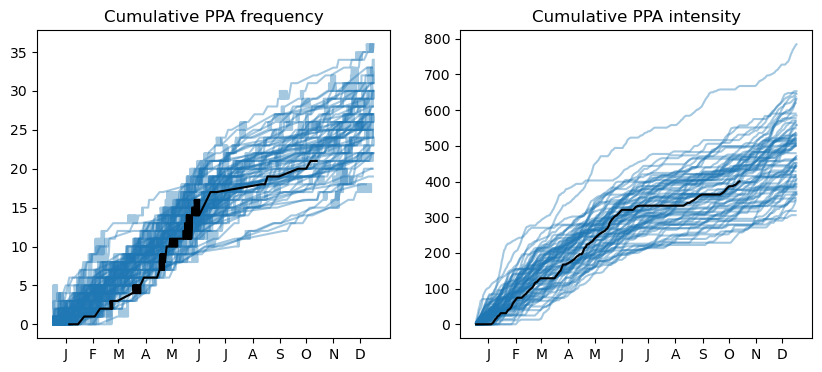

In [311]:
df_daily = df.int.resample("D").sum()

fig, axs = plt.subplots(ncols = 2, figsize = (10,4), dpi = 100)
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
days = pd.date_range(start = "2020-01-01", end = "2020-12-31")
labelticks = [i+1 for i in range(366) if (days[i].day) == 15]
labels = [days[i].strftime("%b")[:1] for i in range(366) if (days[i].day) == 1]

for ax in axs:
    ax.set_xticks(labelticks)
    ax.set_xticklabels(labels)
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
ax = axs[0]
for y in range(1950,2024):
    df_y = df.loc[str(y)].sort_index()
    ax.plot(df_y.index.day_of_year, (df_y.id - min(df_y.id)).values, color = "tab:blue", alpha = 0.4)
    
y = 2023
dsr_y = df_daily.loc[str(y)]
ax.plot(df_y.index.day_of_year, (df_y.id - min(df_y.id)).values, color = "k", alpha = 1, label = "2023")
ax.set_title("Cumulative PPA frequency")
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
ax = axs[1]
for y in range(1950,2024):
    df_y = df_daily.loc[str(y)]
    ax.plot(df_y.index.day_of_year, df_y.cumsum().values, color = "tab:blue", alpha = 0.4)

# # 95th percentile of cumsum
# ax.plot(dsr_ts.sel(time = "2022").time.dt.dayofyear, hfrz_cdsr.isel(region = i).groupby("time.dayofyear").quantile(0.95)[:-1], color = "darkred", alpha = 0.5, label = "95th percentile")

y = 2023
dsr_y = df_daily.loc[str(y)]
ax.plot(df_y.index.day_of_year, df_y.cumsum().values, color = "k", alpha = 1, label = "2023")
ax.set_title("Cumulative PPA intensity")
# #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

---
# **Maps of results**


## **Fitted trend**
_Map of alpha parameters fitted in R_

In [20]:
alpha = pd.merge(hfrz, pd.read_csv("res/logcumdsr_lineartrend-parameter.csv", index_col = 0), left_on = "NAMES_SHOR", right_index = True)

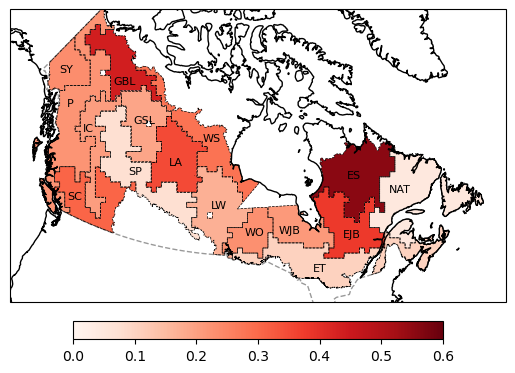

In [63]:
fig, ax = plt.subplots(subplot_kw = {"projection" : cproj}, dpi = 100)

alpha.plot(ax = ax, column = "x", vmin = 0, vmax = 0.6, cmap = "Reds", legend = True, 
           legend_kwds = {"location" : "bottom", "fraction" : 0.05, "pad" : 0.05, "shrink" : 0.9})
ax.coastlines()
ax.add_feature(cartopy.feature.BORDERS, ls = "--", color = "k", alpha = 0.4)
hfrz.boundary.plot(ax = ax, color = "k", lw = 0.5, ls = "--")
[ax.annotate(k, xy = v, fontsize = 8) for k, v in hfrz_px.items()]

plt.savefig("fig/mdl_gmst-coeff-per-hfrz_map.png")